# Block VQE by Qubit

Here we will split the Hilbert space into two groups, one which will be calculated classically and the other with will be calculated using block-VQE.  Instead of splitting the Hilbert space into spin-up and spin-down as we did before, here I will split the Hilbert space into general sets of qubits.  

The wavefunction is divided into classical and quantum parts
$$
    |\psi> = \sum_c \alpha_c |c>|\psi_{qc}>
$$
where $|c>$ is a basis state in the classical section and $|\psi_q>$ is the wavefunction in the quantum section.  The weights $\alpha_c$ have to be solved classically while the wavefunctions $|\psi_{qc}>$ will be updated using VQE.  

Let's do a simple X-Y-Z model with closed boundary conditions to test the algorithm.  
$$ 
    H =  \sum_{i} \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right) 
$$

Let us take the first $N_c$ qubits to be in the classical sector.  Then we can take energy expectation values as,
\begin{equation}
\begin{split}
&<\psi|H|\psi> = \sum_{cc'}\alpha_c\alpha_c'<\psi_{qc'}|<c'| H |c> |\psi_{qc}>=
\\
& \sum_{cc'}\alpha_c\alpha_c' \left( \sum_{i=0}^{N_c-2}  <c'|\left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right)|c><\psi_{qc'}|\psi_{qc}>  + \delta_{cc'}\sum_{i=N_c+1}^{N} <\psi_{qc'}| \ \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right) |\psi_{qc}> \right) 
\\
&+ \sum_{cc'}\alpha_c\alpha_c'  \left( <c'|X_{N_c-1}|c><\psi_{qc'}|X_{N_c}|\psi_{qc}> + <c'|Y_{N_c-1}|c> <\psi_{qc'}|Y_{N_c}|\psi_{qc}> + <c'|Z_{N_c-1}|c><\psi_{qc'}|Z_{N_c}|\psi_{qc}> \right) 
\end{split}
\end{equation}

Anything in the classical brakets are calculated classically while anything in the quantum brackets are calculated using quantum hardware.  Notice that some of the quantum brakets are wieghted by classical brackets.  This is not a problem.  

In [1]:
#Only needed if running on the quantum device
from qiskit import IBMQ,transpile
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')
#backend = provider.get_backend('ibmq_bogota')
backend = provider.get_backend('ibmq_manila')

## Classical part

### Define Pauli Matrices

Let us define the Pauli matrices so we can do the classical calculations.

In [360]:
import qiskit.quantum_info as qi

def X(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'X'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Y(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Y'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Z(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Z'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

### Generate the states

We need a function which gives you the classical basss for a given number of qubits.

In [361]:
# A function to print the state given the numerical represenations
def bi(num,N):
    bi = bin(num)
    out = []
    Sdiff = N - len(bi) + 2
    for i in range(0,Sdiff):
        out.append(0)
    for i in range(2,len(bi)):
        out.append(int(bi[i]))
    return out

# A function which retruns the numerical representation of states given N
def states(N):
    out = [i for i in range(0,2**N)]
    return out

# A function to print the basis vectors given the number of qubits N
def vecs(N):
    out = []
    for i in range(2**N):
        v = [0 for i in range(2**N)]
        v[i] = 1
        out.append(v)
    return out

In [362]:
import numpy as np

def Mdot(Ol):
    out = Ol[0]
    for i in range(1,len(Ol)):
        out = np.dot(Ol[i],out)
    return out

def bkt(y1,O,y2):
    return Mdot([np.conjugate(y1),O,y2])


### Full Hamiltoniain

Let us write the un-partitioned Hamiltonain so we can compare to it later.

In [363]:
def H(x,y,z,N):
    h = 0*X(0,N)
    for i in range(0,N-1):
        h += x*Mdot([X(i,N),X(i+1,N)]) + y*Mdot([Y(i,N),Y(i+1,N)]) + z*Mdot([Z(i,N),Z(i+1,N)])
    return h
        
    
import pandas as pd
#pd.DataFrame(H(1,2,3,4))

### Calculating the classical brakets

We can calculate all of the classical brakets before we start VQE.  Once we have the value of each braket we simply store it as a weight for the various quantum brakets.  There are five types of classical brakets we need to calculate.

\begin{equation}
\begin{split}
& T_{c,c'} =  <c'|\sum_{i=0}^{N_c-2}\left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right)|c> 
\\
& B1^x_{c,c'} =  x<c'|X_{N_c-1}|c>
\\
&B1^y_{c,c'} = y<c'|Y_{N_c-1}|c> 
\\
&B1^z_{c,c'} = z<c'|Y_{N_c-1}|c> 
\end{split}
\end{equation}

In [364]:
def T(x,y,z,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    for i in range(0,Nc-1):
        O = x*Mdot([X(i,Nc),X(i+1,Nc)]) + y*Mdot([Y(i,Nc),Y(i+1,Nc)]) + z*Mdot([Z(i,Nc),Z(i+1,Nc)])
        out += bkt(v[cc],O,v[c])
    return out

def Bx(x,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = X(Nc-1,Nc)
    out += bkt(v[cc],x*O,v[c])
    return out

def By(y,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = Y(Nc-1,Nc)
    out += bkt(v[cc],y*O,v[c])
    return out

def Bz(z,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = Z(Nc-1,Nc)
    out += bkt(v[cc],z*O,v[c])
    return out



We Can use these to rewrite the Hamiltoniain.  I will shift the indicies so $ N_c \rightarrow 0 $.

\begin{equation}
\begin{split}
H_{c,c'}=& T_{c,c'} + \delta_{cc'}\sum_{i=0}^{N_q} \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1}  + z Z_{i} Z_{i+1}\right) 
\\
&+ \left(B^{1x}_{c,c'}X_{0} + B^{1y}_{c,c'} Y_{0} + B^{1z}_{c,c'} Z_{0} \right)
\end{split}
\end{equation}

In [365]:
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi


def H_quantum(x,y,z,c,cc,Nc,Nq):
    tcc = T(x,y,z,c,cc,Nc)
    Iq = np.identity(2**Nq)
    h = tcc*Iq
    h += Bx(x,c,cc,Nc)*X(0,Nq)
    h += By(y,c,cc,Nc)*Y(0,Nq)
    h += Bz(z,c,cc,Nc)*Z(0,Nq)
    if c == cc:
        for i in range(0,Nq-1):
            h += x*Mdot([X(i,Nq),X(i+1,Nq)]) + y*Mdot([Y(i,Nq),Y(i+1,Nq)]) + z*Mdot([Z(i,Nq),Z(i+1,Nq)])
    return h
    
    
#H_quantum(1,1,1,3,2,2,2)

In [366]:
def H_quantum(x,y,z,c,cc,Nc,Nq):
    tcc = T(x,y,z,c,cc,Nc)
    Iq = np.identity(2**Nq)
    h = [MatrixOp(tcc*Iq).to_pauli_op()]
    h.append(MatrixOp(Bx(x,c,cc,Nc)*X(0,Nq)).to_pauli_op())
    h.append(MatrixOp(By(y,c,cc,Nc)*Y(0,Nq)).to_pauli_op())
    h.append(MatrixOp(Bz(z,c,cc,Nc)*Z(0,Nq)).to_pauli_op())
    if c == cc:
        for i in range(0,Nq-1):
            h.append(MatrixOp(x*Mdot([X(i,Nq),X(i+1,Nq)])).to_pauli_op())
            h.append(MatrixOp(y*Mdot([Y(i,Nq),Y(i+1,Nq)])).to_pauli_op())
            h.append(MatrixOp(z*Mdot([Z(i,Nq),Z(i+1,Nq)])).to_pauli_op())
    return h

In [367]:
from qiskit.opflow import SummedOp, PauliOp

def Blocks(x,y,z,Nc,Nq):
    bks = {}
    Mc = len(states(Nc))
    for c in range(0,Mc):
        for cc in range(0,Mc):
            Op = H_quantum(x,y,z,c,cc,Nc,Nq)
            bks[str(c) + ',' + str(cc)] =  Op
    return bks
        
    

In [335]:
Blocks(1,2,3,2,3)['0,0']

[PauliOp(Pauli('III'), coeff=3.0),
 PauliOp(Pauli('III'), coeff=0.0),
 PauliOp(Pauli('III'), coeff=0.0),
 PauliOp(Pauli('ZII'), coeff=3.0),
 PauliOp(Pauli('XXI'), coeff=1.0),
 PauliOp(Pauli('YYI'), coeff=2.0),
 PauliOp(Pauli('ZZI'), coeff=3.0),
 PauliOp(Pauli('IXX'), coeff=1.0),
 PauliOp(Pauli('IYY'), coeff=2.0),
 PauliOp(Pauli('IZZ'), coeff=3.0)]

Let us check that we can rebuild the Hamiltoniain.

In [342]:
Nc = 2
Nq = 3
x = 1
y = 2
z = 3
blocks = Blocks(x,y,z,Nc,Nq)

keys = list(blocks.keys())

bL = len(states(Nc))
size = 2**Nq
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            hl = blocks[key]
            block = np.sum(hl).to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-342-ef49c2b99a7a>:24: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-342-ef49c2b99a7a>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [343]:
np.amax(np.abs(H_complete - np.real(H(x,y,z,Nc+Nq))))

0.0

### Regrouping the blocks in commuting sets

Let us redefine how the blocks are collected we will have the even and odd sets:

the even group:
$$ G_{Ec,c'} = \delta_{c,c'}\{X_0X_1, X_2X_3, X_4X_5, Y_0Y_1, Y_2Y_3, Y_4Y_5, Z_0Z_1, Z_2Z_3, Z_4Z_5\} $$
and the odd group:
$$ G_{Oc,c'} = \delta_{c,c'}\{ X_1X_2, X_3X_4, Y_1Y_2, Y_3Y_4, Z_1Z_2, Z_3Z_4 \} $$

All elements of these sets commute with the elements of the same set but not with the other set.  We also have the boundary set

$$ G_{Bc,c'} = \{B^x_{c,c'}X_0, B^y_{c,c'}Y_0, B^z_{c,c'}Z_0\} $$

These elements do not commute with each other but are collected for convenience.  Then we have the identity set.

$$ G_{Ic,c'} = \{T_{c,c'}\} $$

I keep the idenity in its own set for clearity but eventually it will be measured with either the even or odd set when $c=c'$ otherwise it must be measure alone.

In [338]:
def GI(x,y,z,Nc,Nq):
    bks = {}
    Mc = len(states(Nc))
    Iq = np.identity(2**Nq)
    for c in range(0,Mc):
        for cc in range(0,Mc):
                Op = MatrixOp(T(x,y,z,c,cc,Nc)*Iq).to_pauli_op()
                bks[str(c) + ',' + str(cc)] =  Op
    return bks

def GE(x,y,z,Nc,Nq):
    bks = {}
    Mc = len(states(Nc))
    for c in range(0,Mc):
        Op = []
        for i in range(0,Nq-1,2):
            Op.append(MatrixOp(x*Mdot([X(i,Nq),X(i+1,Nq)])).to_pauli_op())
            Op.append(MatrixOp(y*Mdot([Y(i,Nq),Y(i+1,Nq)])).to_pauli_op())
            Op.append(MatrixOp(z*Mdot([Z(i,Nq),Z(i+1,Nq)])).to_pauli_op())  
        bks[str(c) + ',' + str(c)] =  Op
    return bks

def GO(x,y,z,Nc,Nq):
    bks = {}
    Mc = len(states(Nc))
    for c in range(0,Mc):
        Op = []
        for i in range(1,Nq-1,2):
            Op.append(MatrixOp(x*Mdot([X(i,Nq),X(i+1,Nq)])).to_pauli_op())
            Op.append(MatrixOp(y*Mdot([Y(i,Nq),Y(i+1,Nq)])).to_pauli_op())
            Op.append(MatrixOp(z*Mdot([Z(i,Nq),Z(i+1,Nq)])).to_pauli_op())
        bks[str(c) + ',' + str(c)] =  Op
    return bks

def GB(x,y,z,Nc,Nq):
    bks = {}
    Mc = len(states(Nc))
    for c in range(0,Mc):
        for cc in range(0,Mc):
            Op = []
            Op.append(MatrixOp(Bx(x,c,cc,Nc)*X(0,Nq)).to_pauli_op())
            Op.append(MatrixOp(By(y,c,cc,Nc)*Y(0,Nq)).to_pauli_op())
            Op.append(MatrixOp(Bz(z,c,cc,Nc)*Z(0,Nq)).to_pauli_op())
            bks[str(c) + ',' + str(cc)] =  Op
    return bks

In [339]:
print(GI(1,2,3,2,3)['0,0'])
print(GB(1,2,3,2,3)['0,0'])
print(GE(1,2,3,2,3)['0,0'])
print(GO(1,2,3,2,3)['0,0'])

3.0 * III
[PauliOp(Pauli('III'), coeff=0.0), PauliOp(Pauli('III'), coeff=0.0), PauliOp(Pauli('ZII'), coeff=3.0)]
[PauliOp(Pauli('XXI'), coeff=1.0), PauliOp(Pauli('YYI'), coeff=2.0), PauliOp(Pauli('ZZI'), coeff=3.0)]
[PauliOp(Pauli('IXX'), coeff=1.0), PauliOp(Pauli('IYY'), coeff=2.0), PauliOp(Pauli('IZZ'), coeff=3.0)]


Let's check that we can recreate the Hamiltonain from this grouping of the blocks.

In [340]:
Nc = 2
Nq = 3
x = 1
y = 2
z = 3
ge = GE(x,y,z,Nc,Nq)
go = GO(x,y,z,Nc,Nq)
gb = GB(x,y,z,Nc,Nq)
gi = GI(x,y,z,Nc,Nq)

ge_keys = list(ge.keys())
go_keys = list(go.keys())
gb_keys = list(gb.keys())
gi_keys = list(gi.keys())

bL = len(states(Nc))
size = 2**Nq
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        block = np.array([[0.0 for i in range(size)] for j in range(size)])
        key = str(bi) + ',' + str(bj)
        if key  in ge_keys:
            hl = ge[key]
            block = block + np.sum(hl).to_matrix()
        if key  in go_keys:
            hl = go[key]
            block = block + np.sum(hl).to_matrix()
        if key  in gb_keys:
            hl = gb[key]
            block = block + np.sum(hl).to_matrix()
        if key  in gi_keys:
            hl = gi[key]
            block = block + np.sum(hl).to_matrix()   
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-340-410d8ac116ed>:38: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-340-410d8ac116ed>:39: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [341]:
np.amax(np.abs(H_complete - np.real(H(x,y,z,Nc+Nq))))

0.0

## Anzats Circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [63]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute

Q = Nq

### Diagonal Blocks

In [64]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

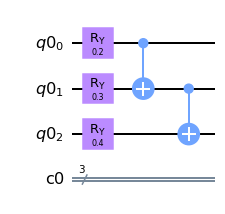

In [65]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

In [66]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir

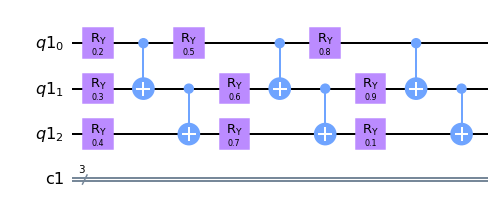

In [67]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

### Off Diagonal Blocks

In [68]:
def Ui_off(cir_i,phi_a, phi_b):  
    
    for q in range(0,Q):
        cir_i.ry(phi_a[q],q)
        cir_i.cx(Q,q)
        cir_i.ry(-(phi_b[q]-phi_a[q])/2,q)
        cir_i.cx(Q,q)
        cir_i.ry((phi_b[q]-phi_a[q])/2,q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

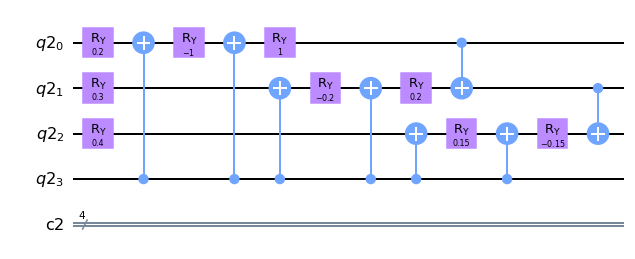

In [69]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
tst = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

tst.draw(output = 'mpl')

In [70]:
#An example block a circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_a = Ui(cir_i,[0.2,0.3,0.4])

#An example block b circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_b = Ui(cir_i,[2.2,0.7,0.1])

#The combination of the two blocks
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
cir_i.h(Q)
tst_off = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

print('A:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_a).data)
print('B:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_b).data)
print('AB:')
print(qi.Statevector.from_instruction(tst_off).data)

A:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j]
B:
[0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]
AB:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j
 0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]


In [71]:
def U_off(cir,phi_a,phi_b):
    T = len(phi_b)
    cir.h(Q)
    for t in range(T):
        cir = Ui_off(cir,phi_a[t],phi_b[t])
    return cir

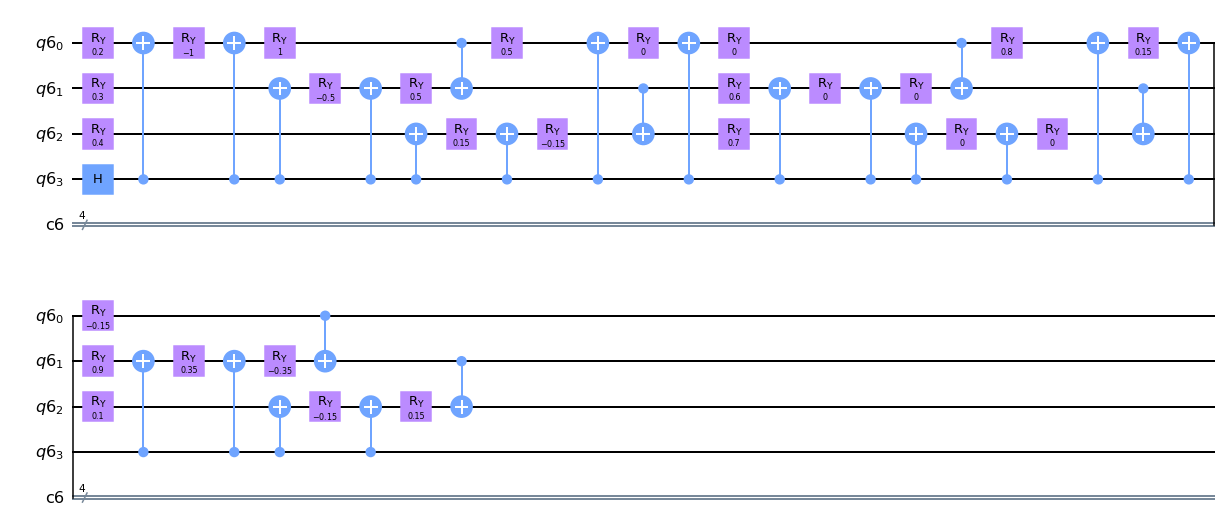

In [72]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
tst = U_off(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]],[[2.2,1.3,0.1],[0.5,0.6,0.7],[0.5,0.2,0.4]])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi|H_{ab}|\psi> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi\})H_{ab}U(\{\phi\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  Then we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi\})  P_{ab,p}U(\{\phi\})|000\ldots>$$.

instead of measuring each Pauli seperately, we will measure them in groups.

\begin{equation}
\begin{split} 
E = &\sum_{a}\sum_{p\in G_E} c_{a,p} <000\ldots|U^{\dagger}(\{\phi\})  P_{aa,p}U(\{\phi\})|000\ldots> 
\\+ &\sum_{a}\sum_{p\in G_O} c_{a,p} <000\ldots|U^{\dagger}(\{\phi\})  P_{aa,p}U(\{\phi\})|000\ldots> 
\\+ &\sum_{ab}\sum_{p\in G_B} c_{ab,p} <000\ldots|U^{\dagger}(\{\phi\})  P_{ab,p}U(\{\phi\})|000\ldots>
\\+ &\sum_{ab}\sum_{p\in G_I} c_{ab,p} .
\end{split}
\end{equation}

We can diagonalize all the terms in $G_E$ and $G_O$ at the same time.

\begin{equation}
\begin{split} 
E = &\sum_{a} c_{a} <000\ldots|U^{\dagger}(\{\phi\}) V^{\dagger}_{E} D_E V_E U(\{\phi\})|000\ldots> 
\\+ &\sum_{a} c_{a} <000\ldots|U^{\dagger}(\{\phi\}) V^{\dagger}_O D_O V_O U(\{\phi\})|000\ldots> 
\\+ &\sum_{ab}\sum_{p\in G_B} c_{ab,p} <000\ldots|U^{\dagger}(\{\phi\})  P_{ab,p}U(\{\phi\})|000\ldots>
\\+ &\sum_{ab} c_{ab} .
\end{split}
\end{equation}

The $V_E$ and $V_O$ operators are built out of Hadamard and Cnot gates.
$$ <H_iC_{ij} X_iX_j C_{ij}H_i> = Z_i$$
$$ <H_iC_{ij} Z_iZ_j C_{ij}H_i> = Z_j$$
$$ <H_iC_{ij} Y_iY_j C_{ij}H_i> = -Z_iZ_j$$

First we do a measurment for the basis of a block

In [351]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def measure_even_odd(psi0, group, method = 'matrix'):
    N_q = len(psi0.qubits)       
    
    psi = copy.deepcopy(psi0)
    #apply rotations#################
    if group == 'even':
        for i in range(0,N_q-1,2):
            psi.cx(Nq-1-i,Nq-1-i-1)
            psi.h(Nq-1-i)
    elif group == 'odd':
        for i in range(1,N_q-1,2):
            psi.cx(Nq-1-i,Nq-1-i-1)
            psi.h(Nq-1-i)
    else:
        print('Group was not recognized.  No rotations where applied')
    ################################
    
    #Using matrix multiplication####
    if method == 'matrix':
        # add results
        wave = qi.Statevector.from_instruction(psi)
        r = wave.probabilities_dict() 
        return r
    #################################
    
    #Using the qasm simulator########
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        psi.measure(psi.qubits,psi.clbits)
        r = execute(psi, backend = sim).result().get_counts()
        total = 0
        for key in list(r.keys()):
            total += r[key]
        for key in list(r.keys()):
            r[key] = r[key]/total
        return r
    ###################################
    
    #Using the quantum backend#########
    if method == "quantum":
        psi.measure(psi.qubits,psi.clbits)
        job = backend.run(transpile(psi, backend), meas_level=2, shots=8192) 
        print("job id: ",job.job_id())
        print(job_monitor(job))
        r = job.result().get_counts()
        for key in list(r.keys()):
            total += r[key]
        for key in list(r.keys()):
            r[key] = r[key]/total
        return r
    ###################################
    
    raise NameError(method + ' is not a recognized method')
    return method + ' is not a recognized method'


#Run a test
import copy
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[[1.2,2.3,3.4]])
p_label = blocks['0,0'][7].primitive.to_label()
        
print('even')
print(measure_even_odd(psi0,'even',method = 'matrix') )
print(measure_even_odd(psi0,'even',method = 'simulator') )
print('odd')
print(measure_even_odd(psi0,'odd',method = 'matrix') )
print(measure_even_odd(psi0,'odd',method = 'simulator') )

even
{'000': 0.009870378704175805, '001': 0.0046197633627548355, '010': 0.5846983795056494, '011': 0.2736640845157799, '100': 0.001437806246327295, '101': 0.0006729553970115412, '110': 0.08517231278218398, '111': 0.03986431948611691}
{'101': 0.0009765625, '110': 0.0830078125, '001': 0.0048828125, '111': 0.0380859375, '011': 0.2822265625, '000': 0.01171875, '010': 0.5791015625}
odd
{'000': 0.017165880548556653, '001': 0.2316441359547055, '010': 0.03703699890098598, '011': 0.3308601651823489, '100': 0.046393995779058, '101': 0.08570884013760693, '110': 0.06626511413148733, '111': 0.18492486936525032}
{'011': 0.337890625, '111': 0.1865234375, '100': 0.044921875, '110': 0.072265625, '001': 0.2265625, '101': 0.0751953125, '000': 0.0205078125, '010': 0.0361328125}


Then we add up the measurments for a given Pauli

In [352]:
def add_up_pauli(p_label,measurment,group):
    pauli_qs = []
    Q = len(p_label)
    if group == 'even':
        qi = 0
    if group == 'odd': 
        qi = 1
        pauli_qs.append(0)
    for q in range(qi,Q-1,2):
        if p_label[q] == 'X':
            pauli_qs.append(1)
            pauli_qs.append(0)
            sign = 1
        if p_label[q] == 'Y':
            pauli_qs.append(1)
            pauli_qs.append(1)
            sign = -1
        if p_label[q] == 'Z':
            pauli_qs.append(0)
            pauli_qs.append(1)
            sign = 1
        if p_label[q] == 'I':
            pauli_qs.append(0)
            pauli_qs.append(0)
            sign = 1
    if len(pauli_qs) < len(p_label):
        pauli_qs.append(0)
    #print(p_label)
    #print(pauli_qs)
    
    r = measurment
    z_measure = 0
    for key in list(r.keys()):
        n = 0
        for q in range(len(key)):
            if key[q] == '1' and pauli_qs[q] == 1:
                n += 1
        z_measure += (-1)**n * r[key] 
    return sign*z_measure

In [353]:
meas = measure_even_odd(psi0,'odd',method = 'matrix')
p_label = go['0,0'][0].primitive.to_label()
xx = add_up_pauli(p_label,meas,'odd')
xx_old = measure_pauli(p_label,psi0,method = 'matrix')
print(xx)
print(xx_old)

meas = measure_even_odd(psi0,'odd',method = 'matrix')
p_label = go['0,0'][2].primitive.to_label()
zz = add_up_pauli(p_label,meas,'odd')
zz_old = measure_pauli(p_label,psi0,method = 'matrix')
print(zz)
print(zz_old)

meas = measure_even_odd(psi0,'odd',method = 'matrix')
p_label = go['0,0'][1].primitive.to_label()
yy = add_up_pauli(p_label,meas,'odd')
yy_old = measure_pauli(p_label,psi0,method = 'matrix')
print(yy)
print(yy_old)

meas = measure_even_odd(psi0,'even',method = 'matrix')
p_label = ge['0,0'][0].primitive.to_label()
xx = add_up_pauli(p_label,meas,'even')
xx_old = measure_pauli(p_label,psi0,method = 'matrix')
print(xx)
print(xx_old)

meas = measure_even_odd(psi0,'even',method = 'matrix')
p_label = ge['0,0'][2].primitive.to_label()
zz = add_up_pauli(p_label,meas,'even')
zz_old = measure_pauli(p_label,psi0,method = 'matrix')
print(zz)
print(zz_old)

meas = measure_even_odd(psi0,'even',method = 'matrix')
p_label = ge['0,0'][1].primitive.to_label()
yy = add_up_pauli(p_label,meas,'even')
yy_old = measure_pauli(p_label,psi0,method = 'matrix')
print(yy)
print(yy_old)

-0.23817429516014543
-0.2381742951601454
-0.6662760212798235
-0.6662760212798237
-0.15868982175042812
-0.15868982175042817
0.7457052121767203
0.7457052121767203
-0.9667981925794606
-0.9667981925794609
0.7209464513295365
0.7209464513295365


For the boundary group we will use the old way of measuring individual Puali matrices.

In [354]:
def measure_pauli(p_label,psi0,method = 'matrix'):
    
        
    #apply rotations#################
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    ################################
    
    #Using matrix multiplication####
    if method == 'matrix':
        # add results
        wave = qi.Statevector.from_instruction(psi)
        r = wave.probabilities_dict()
        z_measure = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
        return z_measure
    #################################
    
    #Using the qasm simulator########
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        psi.measure(psi.qubits,psi.clbits)
        r = execute(psi, backend = sim).result().get_counts()
        z_measure = 0
        total = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
            total += r[key]
        return z_measure/total
    ###################################
    
    #Using the quantum backend#########
    if method == "quantum":
        psi.measure(psi.qubits,psi.clbits)
        job = backend.run(transpile(psi, backend), meas_level=2, shots=8192) 
        print("job id: ",job.job_id())
        print(job_monitor(job))
        r = job.result().get_counts()
        z_measure = 0
        total = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
            total += r[key]

        z_measure/total
        return z_measure/total
    ###################################
    
    raise NameError(method + ' is not a recognized method')
    return method + ' is not a recognized method'
  
    
#Run a test
import copy
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[[1.2,2.3,3.4]])
p_label = blocks['0,0'][7].primitive.to_label()
        

print( measure_pauli(p_label,psi0,method = 'matrix') )
print( measure_pauli(p_label,psi0,method = 'simulator') )

-0.2381742951601454
-0.171875


In [355]:
#print( measure_pauli(p_label,psi0,method = 'quantum') )

In order to calculate things like 
$$<\psi^a|ZZ|\psi^b>$$ 
we will need to add another qubit and build the combined statevector 
$$ |\psi^{ab}> = |0>|\psi^a> + |1>|\psi_b> $$
then we can calculate
$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = <\psi^{a}|ZZ|\psi^{b}> + <\psi^{b}|ZZ|\psi^{a}>  $$ 
$$ <\psi^{ab}|Y\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = i<\psi^{a}|ZZ|\psi^{b}> - i<\psi^{b}|ZZ|\psi^{a}>  $$ 

$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> +  i <\psi^{ab}|Y\otimes ZZ|\psi^{ab}> = <\psi^{a}|ZZ|\psi^{b}> $$

In order to form the combined statevector we need to create a circuit which performs 
$$ U^{ab} = I\otimes U^a + X \otimes U^b$$
This as done in the Ansatz section.   Here we will use that result to calculate E.

In [407]:
import random

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#Create an arbitrary collection of rotation angles
T = 1
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            rand = random.random()
            phi_t.append(rand)
        phi_b.append(phi_t)
    phi.append(phi_b)

In [408]:


#Find the energy contribution from diagonal blocks
def E_on_block_old(phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli( p_label,psi,method = method)
        E += w*E_p
    return E

#Find the energy contribution from diagonal blocks
def E_from_GE_block(block,measure,method = 'simple'):
    E = 0
    for p in block:
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = add_up_pauli(p_label,measure,'even')
        E += w*E_p
    return E

#Find the energy contribution from diagonal blocks
def E_from_GO_block(block,measure,method = 'simple'):
    E = 0
    for p in block:
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = add_up_pauli(p_label,measure,'odd')
        E += w*E_p
    return E
        
        
block_even = ge['0,0']
block_odd = go['0,0']
phi_b = phi[0]
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,phi_b)
meas_even = measure_even_odd(psi0,'even',method = 'matrix')
meas_odd = measure_even_odd(psi0,'odd',method = 'matrix')
M_even = np.sum(block_even).to_matrix()
M_odd = np.sum(block_odd).to_matrix()

wave = qi.Statevector.from_instruction(psi0).data

E_even_block = E_from_GE_block(block_even,meas_even)
E_odd_block = E_from_GO_block(block_odd,meas_odd)

print('check_even:',np.dot(np.conjugate(wave),np.dot(M_even,wave)))
print('matrix_even:',E_even_block)
print('check_odd:',np.dot(np.conjugate(wave),np.dot(M_odd,wave)))
print('matrix_odd:',E_odd_block)

#print('mooncheese:',E_on_block(phi_b,block,method = 'mooncheese'))

check_even: (1.849801046399523+0j)
matrix_even: 1.8498010463995227
check_odd: (1.7514199947013398+0j)
matrix_odd: 1.7514199947013396


In [409]:
# Find the energy contribution from off diagonal blocks
def E_off_block_old(phi_a,phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U_off(cir,phi_a,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_px = measure_pauli('X' + p_label,psi,method = method)
        E_py = measure_pauli('Y' + p_label,psi,method = method)
        E += w*(E_px + 1j*E_py)/2
    return E

# Find the energy contribution from off diagonal blocks
def E_gb_block(phi_a,phi_b,block,method = 'matrix'):
    E = 0
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U_off(cir,phi_a,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_px = measure_pauli('X' + p_label,psi,method = method)
        E_py = measure_pauli('Y' + p_label,psi,method = method)
        E += w*(E_px + 1j*E_py)/2
    return E

# Find the energy contribution from off diagonal blocks
def E_gi_block(phi_a,phi_b,block,method = 'matrix'):
    E = 0
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U_off(cir,phi_a,phi_b)
    p = block
    psi = copy.deepcopy(psi0)
    w = p.coeff
    p_label = p.primitive.to_label()
    E_px = measure_pauli('X' + p_label,psi,method = method)
    E_py = measure_pauli('Y' + p_label,psi,method = method)
    E += w*(E_px + 1j*E_py)/2
    return E

block_gb = gb['0,1']
block_gi = gi['0,1']
phi_a = phi[0]
phi_b = phi[1]
M_gb = np.sum(block_gb).to_matrix()
M_gi = np.sum(block_gi).to_matrix()
#A
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_a = U(cir,phi_a)
wave_a = qi.Statevector.from_instruction(psi_a).data
#B
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_b = U(cir,phi_b)
wave_b = qi.Statevector.from_instruction(psi_b).data
print('check:',1/2*np.dot(np.conjugate(wave_a),np.dot(M_gb,wave_b)))
print('matrix:',E_gb_block(phi_a,phi_b,block_gb,method = 'matrix'))

print('check:',1/2*np.dot(np.conjugate(wave_a),np.dot(M_gi,wave_b)))
print('matrix:',E_gi_block(phi_a,phi_b,block_gi,method = 'matrix'))



check: (0.38110065769706025+0j)
matrix: (0.38110065769706014-1.1828645701816853e-16j)
check: 0j
matrix: 0j


In [419]:

# The total energy 
def find_E_old(alpha,phi,blocks,method = 'matrix'):
    E = 0
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            E += alpha[int(key[0])]*alpha[int(key[2])]*E_on_block_old(phi[int(key[0])],blocks[key],method = method)
        else:
            E += 2*alpha[int(key[0])]*alpha[int(key[2])]*E_off_block_old(phi[int(key[0])],phi[int(key[2])],blocks[key],method = method)
    return E

# The total energy 
def find_E(alpha,phi,ge,go,gb,gi,method = 'matrix'):
    E = 0
    for key in list(ge.keys()):
        phi0 = phi[int(key[0])]
        qr = QuantumRegister(Q)
        cr = ClassicalRegister(Q)
        cir = QuantumCircuit(qr , cr)
        psi0 = U(cir,phi0)
        meas_even = measure_even_odd(psi0,'even',method = method)
        E += (np.abs(alpha[int(key[0])])**2)*E_from_GE_block(ge[key],meas_even)
    for key in list(go.keys()):
        phi0 = phi[int(key[0])]
        qr = QuantumRegister(Q)
        cr = ClassicalRegister(Q)
        cir = QuantumCircuit(qr , cr)
        psi0 = U(cir,phi0)
        meas_odd = measure_even_odd(psi0,'odd',method = method)
        E += (np.abs(alpha[int(key[0])])**2)*E_from_GO_block(go[key],meas_odd)
    for key in list(gb.keys()):
        E += 2*alpha[int(key[0])]*alpha[int(key[2])]*E_gb_block(phi[int(key[0])],phi[int(key[2])],gb[key],method = method)
    for key in list(gi.keys()):
        E += 2*alpha[int(key[0])]*alpha[int(key[2])]*E_gi_block(phi[int(key[0])],phi[int(key[2])],gi[key],method = method)

        
    return E
            
print(find_E_old(alpha,phi,blocks))
print(find_E(alpha,phi,ge,go,gb,gi))

(5.409769610438586-2.4936649967166602e-18j)
(5.409769610438586+3.913969842672671e-17j)


First we need to inialize our set of parameters.  To do this we need to decide on the number of times we will apply Ui.  As a first attempt let's just have a depth of 1 (i.e. $U = Ui$).  

In this case, we need a parameter for each qubit for each section.

In [428]:
alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 2
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)
    
print(find_E_old(alpha,phi,blocks,method = 'matrix'))
print(find_E(alpha,phi,ge,go,gb,gi, method = 'matrix'))

(7+0j)
(6.999999999999999+0j)


# Optimizaition

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [423]:
import copy

In [429]:
#beta = 0.602
beta = 0.201
A = 10
a = 0.05
gamma = 0.101
c = 0.4

beta_a = 0.201
A_a = 10
a_a = 0.05
gamma_a = 0.101
c_a = 0.4

def SPSA(k_max,method = 'simple',hold = False):
    #Initalization
    k = 0
    phi_k = np.array(phi)
    alpha_k = np.array(alpha)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p=0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
            
        #Find E    
        E_A = find_E(alpha_k_A, phi_k_A, ge,go,gb,gi, method = method)
        E_B = find_E(alpha_k_B, phi_k_B, ge,go,gb,gi, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Calculate new E
        E_f = np.real(find_E(alpha_k,phi_k, ge,go,gb,gi, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [430]:
out = SPSA(2000,method = 'matrix',hold = True)

k= 0 c_k= 0.4 a_k= 0.030878064824598282 g= 1.5178807378513182 E_A= (5.681403895363914-3.134232968788424e-17j) E_B= (4.46709930508286-2.316268869828079e-16j) E_f= 6.778344052419123
k= 1 c_k= 0.372954594574733 a_k= 0.030342724499598534 g= -6.260711478255398 E_A= (-0.12358514060779949-9.46688719283759e-17j) E_B= (4.546337081636439-2.624862197104377e-16j) E_f= 3.994595730515227
k= 2 c_k= 0.3579898757427053 a_k= 0.029858459038837503 g= -4.754196318734562 E_A= (0.7016162473309324+1.1134461868984474e-17j) E_B= (4.105524546131358-2.253241809721064e-16j) E_f= 2.6393539601754874
k= 3 c_k= 0.34773782403600867 a_k= 0.029416992458941946 g= 1.495132091327134 E_A= (4.359459029865814-6.506607589148325e-17j) E_B= (3.319631069696805+2.646489091552381e-16j) E_f= 2.5871538266176244
k= 4 c_k= 0.33998833831625347 a_k= 0.02901186589249766 g= 4.841510371904512 E_A= (4.880548147264749+1.4062750902247318e-17j) E_B= (1.5884340146953055-6.274592702152663e-18j) E_f= 2.0592881844863755
k= 5 c_k= 0.3337849224236992 

k= 41 c_k= 0.2742280105583835 a_k= 0.02259713250668938 g= 10.514388126772445 E_A= (-4.703428423849452-1.7557690945786656e-17j) E_B= (-10.470107900336444+2.1882850380876885e-17j) E_f= -10.763733792872634
k= 42 c_k= 0.2735770595127504 a_k= 0.02251078056771661 g= -8.254043507649676 E_A= (-8.923896890965949-4.113048857059933e-17j) E_B= (-4.407662987139736-1.7845158408015804e-16j) E_f= -9.891678640192792
k= 43 c_k= 0.27294256654120025 a_k= 0.022426363573932757 g= -4.138714958770375 E_A= (-8.481820286244714+2.6040872075519105e-16j) E_B= (-6.222557320186226+5.551363461454484e-17j) E_f= -10.000559321301935
k= 44 c_k= 0.27232375538845416 a_k= 0.02234380352009625 g= 2.6921188138629013 E_A= (-5.648759101782649-4.004589496921104e-17j) E_B= (-7.115014912468761+2.1582899468170568e-17j) E_f= -9.67217471326751
k= 45 c_k= 0.27171990265346957 a_k= 0.022263026892257003 g= -2.2615524552765116 E_A= (-6.874203201254317+8.833821413180169e-17j) E_B= (-5.645185575267419-1.5195029515538975e-16j) E_f= -9.4036748

k= 82 c_k= 0.2559959555496353 a_k= 0.020105039545671263 g= 2.983151697135718 E_A= (-7.5734121286736675+6.243426713580216e-17j) E_B= (-9.100761667189216+2.28389367559946e-16j) E_f= -10.927147919031853
k= 83 c_k= 0.2556864912470938 a_k= 0.020061865098160492 g= -0.13557211363793042 E_A= (-8.212004114874937-2.6173281335238714e-16j) E_B= (-8.142676198780867-5.069902826999475e-17j) E_f= -10.922427617697508
k= 84 c_k= 0.2553810568172158 a_k= 0.020019238780586115 g= -6.491685934880325 E_A= (-10.774132428058158-6.943122723108195e-17j) E_B= (-7.458425198907772-9.610159643519835e-17j) E_f= -11.92058901097514
k= 85 c_k= 0.25507955328881354 a_k= 0.019977147973113975 g= -0.09954999624222735 E_A= (-9.93294391776668+1.895203742440614e-17j) E_B= (-9.88215758062394-2.0435023604260722e-16j) E_f= -11.91572069141935
k= 86 c_k= 0.2547818852368658 a_k= 0.019935580474099494 g= -4.231278522076685 E_A= (-8.881872503104137+1.1549748182974129e-17j) E_B= (-6.725766265470224+7.774664537913558e-17j) E_f= -11.3837021

k= 123 c_k= 0.2458240679109626 a_k= 0.018681938577185156 g= 6.949378732897029 E_A= (-9.33695931114069-1.609769888095669e-17j) E_B= (-12.753608410290047-1.4722015532152329e-16j) E_f= -13.346236807048337
k= 124 c_k= 0.24562472416743683 a_k= 0.018654040566102315 g= -4.308180437414276 E_A= (-11.714113455328404+1.746638982017608e-16j) E_B= (-9.597722192121546+1.6165392159611672e-16j) E_f= -13.124528599219069
k= 125 c_k= 0.24542712856241244 a_k= 0.018626389646877888 g= -13.476165231788189 E_A= (-12.839307923065022+8.310921228296546e-17j) E_B= (-6.2244748493242374+6.618308054314153e-17j) E_f= -12.78544263393491
k= 126 c_k= 0.24523125207275073 a_k= 0.01859898183815424 g= 1.5328677186344872 E_A= (-10.079464978737354+3.6643821921917186e-17j) E_B= (-10.831279118542627-1.2720795493637595e-16j) E_f= -12.83128313086971
k= 127 c_k= 0.2450370663809352 a_k= 0.018571813251193444 g= -1.132199057846743 E_A= (-10.042620533648723-4.8360315350137494e-17j) E_B= (-9.487759062260674+1.463538987208125e-16j) E_f=

k= 164 c_k= 0.23883287851005275 a_k= 0.017705955017621747 g= 3.5041055240810937 E_A= (-9.568363497433172-2.1340363165086378e-17j) E_B= (-11.2421547152717-2.6892254772947853e-16j) E_f= -12.693531393533355
k= 165 c_k= 0.238687169536964 a_k= 0.01768568795577825 g= 0.9479218466719873 E_A= (-10.063289191618406+8.746860231655653e-17j) E_B= (-10.515802756667183+8.067320648661376e-17j) E_f= -12.676496650109632
k= 166 c_k= 0.23854242379420307 a_k= 0.01766555872398643 g= -7.874040762581046 E_A= (-11.691354382319105+4.459139210331586e-16j) E_B= (-7.934768845198229-3.6917070856426553e-17j) E_f= -12.370513503637234
k= 167 c_k= 0.23839862920323973 a_k= 0.017645565614109175 g= 3.859840371965823 E_A= (-9.732572764478832+1.4342337951400417e-16j) E_B= (-11.572934071718782-1.9148843889254745e-16j) E_f= -12.635974754803412
k= 168 c_k= 0.2382557739077676 a_k= 0.017625706948624035 g= -0.8654406982743049 E_A= (-10.052591263257673+4.91585618883206e-17j) E_B= (-9.640198776580426-2.392599207273521e-17j) E_f= -1

k= 205 c_k= 0.23353899237344763 a_k= 0.016972460255372947 g= 2.595459932858197 E_A= (-9.25260702517236+2.7039138276595227e-17j) E_B= (-10.464889220103078-1.2614034270515536e-17j) E_f= -12.334857612733297
k= 206 c_k= 0.23342479519724088 a_k= 0.016956710197876357 g= 11.55025042603401 E_A= (-7.141057049354337-9.692335788067513e-17j) E_B= (-12.533286729702002+7.897502761508454e-17j) E_f= -12.683087976451198
k= 207 c_k= 0.23331120380879006 a_k= 0.016941047069765323 g= 6.614351376777369 E_A= (-8.578335226302007-2.830726441469065e-16j) E_B= (-11.66473979056252-4.340657565347521e-17j) E_f= -12.515809918276869
k= 208 c_k= 0.2331982121051757 a_k= 0.016925469995779104 g= 5.963159148850538 E_A= (-7.794032991641383+1.486469097999092e-16j) E_B= (-10.575229095662516-1.6353396620570452e-16j) E_f= -12.148071386427205
k= 209 c_k= 0.23308581407379206 a_k= 0.016909978113415238 g= 5.750490785673804 E_A= (-7.630901103933277-1.507556700898857e-16j) E_B= (-10.311616756138514-2.9583325315882115e-17j) E_f= -11.

k= 246 c_k= 0.2292965915369422 a_k= 0.016389792169700487 g= -0.804498585566423 E_A= (-11.304638952683446-1.421873559942515e-16j) E_B= (-10.935701385550102+3.0622070405633564e-16j) E_f= -13.545406318521254
k= 247 c_k= 0.2292030389611117 a_k= 0.016377003560215587 g= -6.825672626342148 E_A= (-12.85071338072072+7.868334089783814e-17j) E_B= (-9.721783562898134+2.1164231768518443e-17j) E_f= -13.526534122750196
k= 248 c_k= 0.2291099007946226 a_k= 0.016364274344095084 g= -0.9759713047131743 E_A= (-10.36837782352346+1.7394480759315687e-16j) E_B= (-9.921168445920992+2.9386551796015933e-16j) E_f= -13.542928325935424
k= 249 c_k= 0.22901717354849255 a_k= 0.016351604017775957 g= 0.14968473168788984 E_A= (-11.480927033276034+3.0114848519049595e-16j) E_B= (-11.549487781625084+6.953920072684928e-17j) E_f= -13.541963620808374
k= 250 c_k= 0.22892485377692168 a_k= 0.016338992083880566 g= -0.6824511035373118 E_A= (-11.227085125011348+5.401911537510282e-17j) E_B= (-10.914625086836992-3.658210698103363e-16j)

k= 287 c_k= 0.2257674616063849 a_k= 0.015909353626278083 g= 2.1140647592142914 E_A= (-10.410582350309019+1.0546614425514227e-16j) E_B= (-11.365156419027667-7.925420976850302e-17j) E_f= -13.267249942808332
k= 288 c_k= 0.2256884371853021 a_k= 0.015898644391203684 g= 1.8347370141391395 E_A= (-10.792231215469087-3.554256515041985e-16j) E_B= (-11.620389074203267+1.8146306171065004e-16j) E_f= -13.24883571746488
k= 289 c_k= 0.22560971325084006 a_k= 0.015887978086005464 g= 0.305822701978867 E_A= (-11.02725777176512+1.452390080897107e-16j) E_B= (-11.165250915963219-1.7591033923349307e-16j) E_f= -13.250237315908139
k= 290 c_k= 0.2255312876301436 a_k= 0.01587735439634966 g= -6.361451203207344 E_A= (-11.67296768765877+9.682667899677644e-17j) E_B= (-8.803555125547414-5.503724892611034e-17j) E_f= -12.927008549800133
k= 291 c_k= 0.22545315817346873 a_k= 0.015866773011238698 g= -4.3572230463779675 E_A= (-11.357577104430407-5.462341023156564e-16j) E_B= (-9.392877711086136+2.3795085832785503e-17j) E_f= 

k= 328 c_k= 0.22275281734417096 a_k= 0.015502433069694073 g= -4.212691637302324 E_A= (-12.28690888438792-5.449014537588027e-18j) E_B= (-10.410131022765277-3.90416604748123e-16j) E_f= -14.043048918146189
k= 329 c_k= 0.22268454843958294 a_k= 0.015493257608503003 g= 2.303958025988611 E_A= (-9.69860507922969-2.2822227897103367e-16j) E_B= (-10.724716784511743+9.443655255862567e-17j) E_f= -14.043804664785785
k= 330 c_k= 0.22261650692588505 a_k= 0.015484114501177636 g= -0.6454557893245548 E_A= (-11.472195020938024-1.7434483796811815e-16j) E_B= (-11.18481679454898-3.4914721377479994e-17j) E_f= -14.027097792234287
k= 331 c_k= 0.22254869136212244 a_k= 0.015475003539255199 g= -1.8684340412927545 E_A= (-11.58888399015139+9.381241645802855e-17j) E_B= (-10.7572488885791-1.3747916708997822e-16j) E_f= -13.924278882597376
k= 332 c_k= 0.22248110032077717 a_k= 0.015465924516220633 g= 0.9859811504474207 E_A= (-10.988271236079282+9.366108407821511e-17j) E_B= (-11.426995578573457-1.654588098372067e-16j) E_f

k= 369 c_k= 0.220126139528912 a_k= 0.01515072800038149 g= -0.4892139701497643 E_A= (-12.106840532224831+3.717597455760823e-17j) E_B= (-11.891462966919471-7.42017906074184e-17j) E_f= -13.678228166151428
k= 370 c_k= 0.22006614027523438 a_k= 0.015142726702407251 g= 4.9509353565924155 E_A= (-10.711913257541623-1.6646135786544854e-16j) E_B= (-12.89097972689659-2.602267987747637e-16j) E_f= -13.749835080166918
k= 371 c_k= 0.2200063188150296 a_k= 0.015134750586707544 g= 4.694780166814058 E_A= (-9.867551517198839+9.865282194077292e-18j) E_B= (-11.933314121491982-2.7972754557902367e-16j) E_f= -13.84486905544459
k= 372 c_k= 0.219946674145629 a_k= 0.015126799508415159 g= 3.4909622046665594 E_A= (-11.059738519518135-3.483932879271477e-16j) E_B= (-12.59538957248714+4.198670764247747e-16j) E_f= -13.765830890528294
k= 373 c_k= 0.21988720527268746 a_k= 0.015118873323871754 g= -0.791634448258454 E_A= (-11.14721387452547-2.947072322855934e-17j) E_B= (-10.799073301675195-2.5277171017996166e-16j) E_f= -13.

k= 410 c_k= 0.2178020521092889 a_k= 0.014841893231637726 g= 0.5815914697940736 E_A= (-11.615304604466335+2.3100900787677107e-16j) E_B= (-11.868648235687148+1.565456314619185e-16j) E_f= -14.115353046357948
k= 411 c_k= 0.21774860054507708 a_k= 0.01483481728679895 g= -2.751898327944239 E_A= (-12.385382167428403+2.35389233907786e-16j) E_B= (-11.186938147924012-3.1567760528040595e-16j) E_f= -14.167201599879554
k= 412 c_k= 0.21769529163061768 a_k= 0.014827761451299215 g= 3.506354166973999 E_A= (-11.65336016913355+2.1707196225517358e-16j) E_B= (-13.179993755012823+3.987764840916308e-17j) E_f= -14.273740235389203
k= 413 c_k= 0.21764212464119265 a_k= 0.014820725620651613 g= 2.2538265971563263 E_A= (-11.656211605218862-2.068286094534021e-16j) E_B= (-12.637266823574727-1.109637653749828e-16j) E_f= -14.287683344839559
k= 414 c_k= 0.217589098857505 a_k= 0.014813709691156947 g= 3.693168379834187 E_A= (-11.559980766960058-2.0981031277209146e-16j) E_B= (-13.167167126354363+2.1977849308551548e-16j) E_f

k= 450 c_k= 0.21576855871880654 a_k= 0.014573575604562192 g= 3.483828752642326 E_A= (-11.232175303637332+4.5059525311454893e-17j) E_B= (-12.735576721198877-2.529085691790939e-16j) E_f= -14.162218581371178
k= 451 c_k= 0.2157202969335856 a_k= 0.014567229663004258 g= -1.0667005373034084 E_A= (-12.714767069412902-2.247810582783922e-16j) E_B= (-12.254549156120289+3.648685247384135e-18j) E_f= -14.16805833348212
k= 452 c_k= 0.21567215256347394 a_k= 0.014560900196744206 g= 0.47227386132510546 E_A= (-12.381950812684689-1.369625701214794e-16j) E_B= (-12.585663453227587+2.372923683785383e-16j) E_f= -14.166902892187279
k= 453 c_k= 0.2156241250645643 a_k= 0.014554587127563468 g= 1.0095857919229947 E_A= (-12.232112206669022+1.4025688937540634e-16j) E_B= (-12.667494312791044+1.8987617721211593e-16j) E_f= -14.176082078945555
k= 454 c_k= 0.21557621389665993 a_k= 0.014548290377782385 g= 4.503942966369701 E_A= (-11.060443613569301-1.4451573172079392e-16j) E_B= (-13.002329558162245-1.6503838152012186e-16j

k= 490 c_k= 0.21392461576892882 a_k= 0.014331862122056118 g= -0.22304761748837165 E_A= (-12.040462512702204+2.705546694469926e-16j) E_B= (-11.945031760963454+9.716736615577782e-17j) E_f= -13.960806237949887
k= 491 c_k= 0.21388066017622928 a_k= 0.014326119095080895 g= -2.2555040023710884 E_A= (-12.616190536848714+1.8788589147242582e-16j) E_B= (-11.651373166734203-1.2230864834194849e-17j) E_f= -14.069411920321302
k= 492 c_k= 0.21383680283769652 a_k= 0.014320389791489158 g= -1.7052701966973165 E_A= (-12.580751831241363-7.927166686218558e-17j) E_B= (-11.851452777569035-1.8652071648476468e-16j) E_f= -14.037666241356778
k= 493 c_k= 0.21379304333507107 a_k= 0.01431467415130243 g= 4.526880254846154 E_A= (-11.12343183083329-4.928317398919057e-18j) E_B= (-13.059062843827293+6.315907370692825e-17j) E_f= -14.047382510291856
k= 494 c_k= 0.213749381252716 a_k= 0.014308972114922715 g= -8.571386659795914 E_A= (-13.661399630253944-3.718716352966776e-17j) E_B= (-9.997142440235622-4.5411388415602125e-17j

k= 530 c_k= 0.2122391241155684 a_k= 0.014112285504390918 g= 4.863656203964278 E_A= (-11.126908202501212+1.15125454603883e-16j) E_B= (-13.19142446795847+1.9361365095961812e-16j) E_f= -14.183778208389905
k= 531 c_k= 0.21219879651208745 a_k= 0.014107048119713802 g= 0.27748172436894125 E_A= (-12.617691141767995+1.8005758955352e-16j) E_B= (-12.735453717698372-1.5458134799071627e-16j) E_f= -14.187229307530789
k= 532 c_k= 0.2121585522823262 a_k= 0.014101822327547439 g= 0.026804365191377483 E_A= (-12.352756637058711+1.4430293689624924e-16j) E_B= (-12.36413018768641-8.954898097067857e-17j) E_f= -14.188729593980325
k= 533 c_k= 0.21211839109797767 a_k= 0.01409660808095454 g= 5.222454828323062 E_A= (-10.55172414550972+2.3213471743807923e-16j) E_B= (-12.767281577041226-7.220807267484659e-17j) E_f= -14.144177542377072
k= 534 c_k= 0.2120783126326395 a_k= 0.014091405333273698 g= -1.9356818999857113 E_A= (-12.791594803303257+1.145065737851515e-16j) E_B= (-11.970562501018234-2.7646596804416293e-16j) E_f

k= 571 c_k= 0.21065074160592062 a_k= 0.013906584672779863 g= -2.92105962337616 E_A= (-12.757696998622425+2.2212797221516934e-16j) E_B= (-11.527050246743826-5.0854997488812624e-17j) E_f= -14.080979774190643
k= 572 c_k= 0.21061358203614297 a_k= 0.013901786832445216 g= 10.061093737795154 E_A= (-9.533514824908387+8.478679431540959e-17j) E_B= (-13.771520807545276-3.5960301353415983e-16j) E_f= -14.158363779130255
k= 573 c_k= 0.2105764937987169 a_k= 0.013896998865660582 g= 7.531831173890983 E_A= (-10.235059692985295-1.834916412468836e-16j) E_B= (-13.40711289394897-1.4824523607663235e-16j) E_f= -14.114004063321913
k= 574 c_k= 0.2105394766327961 a_k= 0.013892220735252377 g= -2.226782480564142 E_A= (-12.219201304716071+8.088314392870023e-17j) E_B= (-11.281550068649963-6.458859825774517e-17j) E_f= -14.04950324111478
k= 575 c_k= 0.2105025302789397 a_k= 0.013887452404250206 g= 0.09212205217922993 E_A= (-12.235515907826771-1.652715496636917e-16j) E_B= (-12.274299757983204-7.135024345088816e-17j) E_f

k= 611 c_k= 0.20921754307254326 a_k= 0.013722022813102922 g= -3.165224459830664 E_A= (-12.571478417042496-1.2610482825827518e-16j) E_B= (-11.247037447524717-1.373004863760275e-16j) E_f= -14.130266655931342
k= 612 c_k= 0.20918304636329907 a_k= 0.01371759280195691 g= 9.81369581506124 E_A= (-9.16688420236172+3.387232512500024e-16j) E_B= (-13.272601775716259-1.274522565144359e-16j) E_f= -14.015916519142573
k= 613 c_k= 0.209148611557505 a_k= 0.013713171322627967 g= 3.18168167178881 E_A= (-10.609564387617914+1.5893068780289799e-16j) E_B= (-11.940452995763096+1.8322389830391065e-17j) E_f= -13.897350132768153
k= 614 c_k= 0.20911423844352794 a_k= 0.013708758345051218 g= -2.4916724955399907 E_A= (-12.481165504076012+4.286174655141198e-16j) E_B= (-11.439077111364952+2.1026645298582094e-16j) E_f= -13.918470624119898
k= 615 c_k= 0.20907992681080098 a_k= 0.013704353839315616 g= 0.7169569379498817 E_A= (-12.080468809369124+1.207755479547112e-16j) E_B= (-12.380271417595239+6.593320560448588e-17j) E_f=

k= 652 c_k= 0.20785178572027052 a_k= 0.013547082796837265 g= 0.47225005614973437 E_A= (-12.008599169713515-1.3140578260848242e-16j) E_B= (-12.204915204667955+6.655837927439981e-17j) E_f= -13.627912939833601
k= 653 c_k= 0.20781966420186904 a_k= 0.01354297947844509 g= -5.460555914971922 E_A= (-12.519349775241373+1.563494072587671e-17j) E_B= (-10.249727982031384-7.477810955037403e-17j) E_f= -13.795483188431385
k= 654 c_k= 0.20778759671414168 a_k= 0.013538883575164739 g= 4.422734792821388 E_A= (-10.689677320010162-8.315979703970326e-17j) E_B= (-12.52765618701891+1.7743938935927868e-16j) E_f= -13.748727224156085
k= 655 c_k= 0.20775558308392328 a_k= 0.013534795062475995 g= 3.0200208154117054 E_A= (-10.980265894326555-1.3891186141443683e-16j) E_B= (-12.235118265189444+9.662999764537829e-17j) E_f= -13.794673056737077
k= 656 c_k= 0.20772362313886658 a_k= 0.013530713915976387 g= 2.398940892608447 E_A= (-10.898641946036484-1.105325039538626e-16j) E_B= (-11.89527533385371+2.5156602608156897e-16j) 

k= 692 c_k= 0.20660742957376568 a_k= 0.013388501883021677 g= 1.2580178739132164 E_A= (-12.10675064820914+1.5287188244766148e-16j) E_B= (-12.626582326783266+6.984891815971334e-17j) E_f= -14.244305464772783
k= 693 c_k= 0.2065773418527338 a_k= 0.013384677142542892 g= 5.3216222048442745 E_A= (-11.363255308266078+2.094572691573185e-16j) E_B= (-13.561908447108507-1.3155097991967538e-16j) E_f= -14.227135251775739
k= 694 c_k= 0.20654730182670994 a_k= 0.013380858921382034 g= 0.6170765072259452 E_A= (-12.166020752675587-5.363632817027777e-17j) E_B= (-12.420931727851926+1.846781627194417e-16j) E_f= -14.22226820754055
k= 695 c_k= 0.20651730935162516 a_k= 0.0133770471992032 g= 1.076854597264938 E_A= (-12.194785346775781+8.737158990978694e-17j) E_B= (-12.639563574755947-2.435642743013844e-16j) E_f= -14.179502874698597
k= 696 c_k= 0.20648736428405176 a_k= 0.013373241955762607 g= -4.880452797840415 E_A= (-12.975491643111651+5.093409849818834e-16j) E_B= (-10.959987973634064-5.651007231114111e-17j) E_f=

k= 732 c_k= 0.2054397556736062 a_k= 0.013240404487265127 g= 1.7007145692739831 E_A= (-11.879356788542845-1.1810893151793826e-16j) E_B= (-12.578145559707224+2.378710429887839e-16j) E_f= -13.918523042119858
k= 733 c_k= 0.20541146938860758 a_k= 0.013236825520216459 g= -2.2483043178730417 E_A= (-12.721838029776363-4.631071296740506e-16j) E_B= (-11.798183042642258+1.3564492995969372e-17j) E_f= -13.84897312312516
k= 734 c_k= 0.20538322550125063 a_k= 0.013233252325847988 g= 1.9604624891211968 E_A= (-10.957259995014503+1.6242491104104999e-16j) E_B= (-11.762552213994347+1.0760720305575108e-16j) E_f= -13.841790997775526
k= 735 c_k= 0.20535502389043217 a_k= 0.013229684887118858 g= -4.949979480992325 E_A= (-13.065050403151071-8.523900029204273e-17j) E_B= (-11.032044093998415-4.331225376625062e-17j) E_f= -14.035617223595718
k= 736 c_k= 0.20532686443555895 a_k= 0.013226123187061267 g= -4.231489858771635 E_A= (-13.07186325763601-1.677342812018319e-16j) E_B= (-11.334186168451119-2.0227936237532953e-16

k= 772 c_k= 0.20434022273835856 a_k= 0.013101586549648525 g= 0.8541229495016959 E_A= (-11.517952436258028-1.356692645761531e-16j) E_B= (-11.867015783752269-5.956232521229637e-17j) E_f= -14.084611725923455
k= 773 c_k= 0.2043135426892323 a_k= 0.013098225884054921 g= 1.0846218180422027 E_A= (-12.264713687387781+6.317321995287537e-17j) E_B= (-12.707919539632258+3.131857478433638e-16j) E_f= -14.079922463509533
k= 774 c_k= 0.20428690056499513 a_k= 0.01309487036268483 g= -0.531898717690448 E_A= (-11.978726276786297+5.506042250108444e-17j) E_B= (-11.761406395883343-1.5610332659269573e-17j) E_f= -14.106235772291093
k= 775 c_k= 0.20426029626290682 a_k= 0.013091519971125787 g= -1.730299790672574 E_A= (-12.546993226345682+6.870023669498936e-17j) E_B= (-11.840130130612831+5.1740009142787405e-17j) E_f= -14.031603694828709
k= 776 c_k= 0.20423372968063744 a_k= 0.013088174695023973 g= 1.828447945928604 E_A= (-11.894525693461478+1.6750528059257853e-16j) E_B= (-12.641387180509277-2.480997870695589e-17j) 

k= 813 c_k= 0.20327638391063232 a_k= 0.012967869600710736 g= -2.968724945771965 E_A= (-12.762329146368316-1.062643968151317e-16j) E_B= (-11.55538580276469+9.871741321195764e-17j) E_f= -14.309169221485401
k= 814 c_k= 0.20325117869950363 a_k= 0.012964708625066993 g= 0.6547856182056647 E_A= (-11.115128937302824+4.178127007301009e-17j) E_B= (-11.381300834694393+3.3726546250028634e-17j) E_f= -14.33376189856856
k= 815 c_k= 0.203226007515629 a_k= 0.012961552247691495 g= 6.488205347708816 E_A= (-10.626866924205956+6.90129432012601e-17j) E_B= (-13.264011061718788+5.697326804295074e-17j) E_f= -14.235484909933222
k= 816 c_k= 0.20320087027145553 a_k= 0.012958400456340375 g= 0.608520280155002 E_A= (-11.536960888644675+3.147777428524659e-17j) E_B= (-11.784264589655328+3.6455280237667956e-17j) E_f= -14.24615791091434
k= 817 c_k= 0.20317576687976258 a_k= 0.012955253238817114 g= -7.189863556700679 E_A= (-13.350373833909883-5.973513925361375e-17j) E_B= (-10.428761750122847-1.7692005871204639e-16j) E_f= 

k= 853 c_k= 0.20229388099530227 a_k= 0.01284490043027062 g= 4.021722597396082 E_A= (-11.541075985136699+3.217683274516145e-16j) E_B= (-13.16821573016422-3.571403139681893e-16j) E_f= -14.390384503330585
k= 854 c_k= 0.2022699717186844 a_k= 0.012841914282029087 g= -3.3665830231840763 E_A= (-13.099926018422945-5.122532310701211e-16j) E_B= (-11.738008712646852+3.576843986415108e-16j) E_f= -14.278407125619907
k= 855 c_k= 0.2022460932106994 a_k= 0.01283893227699766 g= 0.2923506968308492 E_A= (-11.864410958781171-1.6728012793698894e-16j) E_B= (-11.982664531344101-5.3498747274090104e-18j) E_f= -14.29496586235666
k= 856 c_k= 0.202222245395876 a_k= 0.012835954404653373 g= -3.1279594838710447 E_A= (-12.593913015085892-3.738158249341136e-16j) E_B= (-11.328827034414436-3.2798828447202254e-16j) E_f= -14.210602784045875
k= 857 c_k= 0.2021984281990159 a_k= 0.012832980654512086 g= -1.4780593065226497 E_A= (-11.63961064696818+1.5402989565733465e-16j) E_B= (-11.041888109840565-1.0921002899771884e-17j) E_f

k= 893 c_k= 0.20136078792088513 a_k= 0.012728585666350399 g= -4.202543234515592 E_A= (-12.728408644080927-4.5563987758699154e-17j) E_B= (-11.035953810133638+1.8290667563957204e-16j) E_f= -13.860384821813513
k= 894 c_k= 0.20133805310415154 a_k= 0.012725757405732611 g= 4.394106866494028 E_A= (-11.07459805716772+1.257597555954e-16j) E_B= (-12.843999900430703-1.738427517623208e-16j) E_f= -13.96200920153426
k= 895 c_k= 0.20131534623786648 a_k= 0.012722932895931667 g= -10.757854279869584 E_A= (-13.41448221449481-2.5826411302705787e-16j) E_B= (-9.083039896237892-5.05287736875121e-17j) E_f= -13.985509667813833
k= 896 c_k= 0.20129266725653008 a_k= 0.012720112127841514 g= -7.358283411738794 E_A= (-12.990828305649654+1.830998784970503e-16j) E_B= (-10.02849131689289+9.934202206145045e-17j) E_f= -13.96052494496728
k= 897 c_k= 0.20127001609486886 a_k= 0.012717295092388222 g= -1.984757441501397 E_A= (-12.667730303849495-1.694021579237096e-16j) E_B= (-11.868785979458702+5.0526794842855077e-17j) E_f= -

k= 933 c_k= 0.20047256948666198 a_k= 0.012618293751522744 g= 8.30248943424619 E_A= (-10.369339761782367-1.8732549683150053e-18j) E_B= (-13.69818254182076-1.722198985947489e-16j) E_f= -14.299085248864923
k= 934 c_k= 0.2004509037431516 a_k= 0.012615608725131816 g= -0.024758533392768796 E_A= (-12.391395633379046+2.0584227835344898e-16j) E_B= (-12.381469892591175+4.325903636924965e-17j) E_f= -14.29784406426585
k= 935 c_k= 0.20042926349691575 a_k= 0.012612927108973035 g= 4.087353585287038 E_A= (-10.671979140809489+6.97133888035896e-17j) E_B= (-12.310429678310607+8.292822237370525e-18j) E_f= -14.144393647331327
k= 936 c_k= 0.20040764869075534 a_k= 0.012610248895117056 g= -1.5576660363266608 E_A= (-12.533190435671633+1.8081381719463712e-16j) E_B= (-11.908854060100284-7.371561360456427e-17j) E_f= -14.101111952956419
k= 937 c_k= 0.20038605926766054 a_k= 0.012607574075661319 g= -1.117492756084245 E_A= (-12.467641746810752-5.107219890282723e-17j) E_B= (-12.019781807506995+1.897179325317806e-17j) 

k= 973 c_k= 0.19962527925658788 a_k= 0.012513476707302976 g= 0.660927643816739 E_A= (-11.754675123512516+9.700892796405366e-17j) E_B= (-12.018550854443147-2.9017532653608457e-16j) E_f= -14.329872070011781
k= 974 c_k= 0.19960459058529167 a_k= 0.012510922159518708 g= 0.7233604394916153 E_A= (-12.362845412779047-2.1030364619922267e-16j) E_B= (-12.651617541519688-1.6538609460607476e-16j) E_f= -14.330853144961827
k= 975 c_k= 0.1995839252631003 a_k= 0.012508370724570072 g= 2.7906293473328554 E_A= (-11.664406011296789-4.3532726421573633e-17j) E_B= (-12.778335529486979+4.19470448831809e-17j) E_f= -14.293470803806757
k= 976 c_k= 0.1995632832397793 a_k= 0.012505822395512659 g= -0.9517900049764687 E_A= (-12.014593625510846+1.51725351612838e-16j) E_B= (-11.634708948815026+3.85189541111358e-17j) E_f= -14.31073011366088
k= 977 c_k= 0.19954266446525346 a_k= 0.012503277165424573 g= -1.5146920501342305 E_A= (-12.864758981211825-2.2198544372635206e-16j) E_B= (-12.260267606155582-3.411088780069593e-17j) 

k= 1013 c_k= 0.19881546252700655 a_k= 0.012413656192962948 g= -5.103435149826238 E_A= (-12.905294322027444+2.1689859362164855e-16j) E_B= (-10.876010682448872+1.6242749253589066e-17j) E_f= -14.21472487839727
k= 1014 c_k= 0.19879567015262556 a_k= 0.012411220955926791 g= 0.36554573073213054 E_A= (-11.830917638358207+1.8757817399296237e-16j) E_B= (-11.976255455382857+2.0353563050020464e-16j) E_f= -14.216194614904852
k= 1015 c_k= 0.19877589923597364 a_k= 0.012408788570605397 g= -3.364279636880261 E_A= (-13.066152909255782+1.596221497485294e-16j) E_B= (-11.728677489051485-2.9721019239999213e-16j) E_f= -14.201260150520028
k= 1016 c_k= 0.19875614973270214 a_k= 0.012406359030884776 g= -2.074949003567321 E_A= (-13.025788362982803+9.907064754329313e-17j) E_B= (-12.200970613301308+2.511569278049415e-17j) E_f= -14.172118948060172
k= 1017 c_k= 0.1987364215985975 a_k= 0.012403932330669986 g= 3.494949689192288 E_A= (-12.108769200956646-7.474244408517979e-17j) E_B= (-13.497916790751058+1.40695935421173

k= 1053 c_k= 0.198040078419009 a_k= 0.012318412333635148 g= -0.07366083401736766 E_A= (-12.387406048932577+8.354990602894566e-17j) E_B= (-12.35823045424216-1.444316806480026e-17j) E_f= -14.4153662273702
k= 1054 c_k= 0.19802111104911638 a_k= 0.012316086577585084 g= -1.918076279184255 E_A= (-12.322849856137722-2.7567110730890426e-17j) E_B= (-11.56321066437568-1.5710601892544003e-16j) E_f= -14.401221368286778
k= 1055 c_k= 0.1980021634632864 a_k= 0.01231376344281136 g= 4.202014157167198 E_A= (-11.20062913354943+3.332289297767668e-17j) E_B= (-12.864644921594357+7.198529386905698e-17j) E_f= -14.400385756821994
k= 1056 c_k= 0.19798323562217748 a_k= 0.012311442923904797 g= -3.3792882965597855 E_A= (-13.314607658679405+5.662383838575076e-17j) E_B= (-11.97652279657328+6.977867125632013e-17j) E_f= -14.48893253759924
k= 1057 c_k= 0.19796432748656353 a_k= 0.01230912501547244 g= 1.1998637702025754 E_A= (-12.765351898191003+4.5221791385551235e-17j) E_B= (-13.240412346878294-1.4064281628960527e-16j) E

k= 1093 c_k= 0.1972964367543689 a_k= 0.012227374685916531 g= -2.1536553277734694 E_A= (-13.162622882940077-1.7876364309114863e-17j) E_B= (-12.312805838606542+1.3229025739147947e-16j) E_f= -14.41730341788068
k= 1094 c_k= 0.19727823116085427 a_k= 0.012225149716370565 g= 0.21321576188415328 E_A= (-12.430747048284385-1.4272788813869757e-16j) E_B= (-12.514872705004624-1.9371747113415226e-16j) E_f= -14.426975210572005
k= 1095 c_k= 0.19726004386349408 a_k= 0.012222927163781486 g= -2.1311564923768507 E_A= (-13.389992720688527+2.2493061464075977e-16j) E_B= (-12.549208674356072-1.6928260485032857e-16j) E_f= -14.476738701436359
k= 1096 c_k= 0.19724187482723268 a_k= 0.012220707023342034 g= 0.4619435096975559 E_A= (-12.680229378454008+2.321967702721571e-16j) E_B= (-12.862458586288044+5.256964666883856e-17j) E_f= -14.479496067674022
k= 1097 c_k= 0.19722372401711352 a_k= 0.012218489290258832 g= -4.589197365741886 E_A= (-13.922667364341041-2.8592654935905113e-16j) E_B= (-12.112470174898757+1.487006908

k= 1133 c_k= 0.196582146479834 a_k= 0.012140214870637548 g= -1.7935108523011223 E_A= (-12.704028427586605-3.133095020406832e-16j) E_B= (-11.998884001426143-3.285405642038772e-16j) E_f= -14.453747022031033
k= 1134 c_k= 0.1965646463350041 a_k= 0.012138082962309749 g= -0.9910000896335592 E_A= (-12.522127523503887+1.616560705315189e-17j) E_B= (-12.13253635923033-6.003798822633499e-18j) E_f= -14.442726716393462
k= 1135 c_k= 0.19654716315785803 a_k= 0.012135953288986374 g= -3.0111171959268552 E_A= (-13.148542363855178-1.5995773218196854e-16j) E_B= (-11.964889278264643-3.2426082927516074e-16j) E_f= -14.416915295514253
k= 1136 c_k= 0.19652969691702968 a_k= 0.012133825846377136 g= -0.7183960688572717 E_A= (-12.297235664519516-1.7341849374761203e-16j) E_B= (-12.014863341161705-2.462889300551875e-16j) E_f= -14.42565306581944
k= 1137 c_k= 0.1965122475812385 a_k= 0.01213170063020372 g= 0.7400076053365156 E_A= (-13.066269875272283-5.177461153893633e-16j) E_B= (-13.35711099077606-4.4031435719215856e-

k= 1173 c_k= 0.19589507320012842 a_k= 0.012056640518534122 g= -4.731577894293474 E_A= (-13.44660795615571+2.9799748125694414e-17j) E_B= (-11.59282236024625+1.0477307123499625e-16j) E_f= -14.483609513830931
k= 1174 c_k= 0.19587822811464575 a_k= 0.012054594778318465 g= -2.5995009300911613 E_A= (-13.466920105521178-2.1164503523137095e-17j) E_B= (-12.448548833183917-1.821960176536915e-16j) E_f= -14.544764894756748
k= 1175 c_k= 0.19586139880597675 a_k= 0.012052551110414906 g= 2.2022555500099825 E_A= (-12.524925521743345+8.136392008471548e-17j) E_B= (-13.387599226849707-2.6035670121573953e-16j) E_f= -14.560374260999136
k= 1176 c_k= 0.1958445852459484 a_k= 0.012050509510979553 g= 0.17189057320208503 E_A= (-12.623365045729164+1.6350342245116475e-16j) E_B= (-12.690692721762066-4.085751152827614e-16j) E_f= -14.554746448198433
k= 1177 c_k= 0.19582778740646165 a_k= 0.012048469976178876 g= 0.574538172512446 E_A= (-12.912542743301797-5.486064234502697e-17j) E_B= (-13.137563821509126-8.48013561706471

k= 1213 c_k= 0.1952333039598541 a_k= 0.011976390259088412 g= -0.8940895950440227 E_A= (-13.470138408861025-5.195498745251858e-16j) E_B= (-13.12102627750788+2.221971612587086e-16j) E_f= -14.505905509064768
k= 1214 c_k= 0.19521706868202696 a_k= 0.011974424512242439 g= -1.348811425808551 E_A= (-13.557250499203592+2.0665109254465694e-16j) E_B= (-13.03062847370125+1.4712756192124797e-17j) E_f= -14.489752012625804
k= 1215 c_k= 0.19520084810950644 a_k= 0.011972460691686632 g= 4.325873033120254 E_A= (-11.91011548547286+3.845104371653909e-16j) E_B= (-13.598943655231093+2.30698898978798e-16j) E_f= -14.476633393527234
k= 1216 c_k= 0.19518464221689624 a_k= 0.011970498793964479 g= -0.15214991189011956 E_A= (-12.913858543788443+2.607408990057319e-16j) E_B= (-12.854463891557232-1.366033235186185e-16j) E_f= -14.472934091923358
k= 1217 c_k= 0.1951684509788648 a_k= 0.011968538815628472 g= -2.071608309882407 E_A= (-13.00799493613975+9.07199243868874e-17j) E_B= (-12.199369766390364+4.02877802798448e-17j) 

k= 1253 c_k= 0.19459511784217856 a_k= 0.011899229545097966 g= 3.745613664238555 E_A= (-12.199677047415621+2.7969831455646305e-16j) E_B= (-13.657433312183173+2.668220774544428e-16j) E_f= -14.722997481789466
k= 1254 c_k= 0.19457945158726725 a_k= 0.011897338240090437 g= 1.9534285933119948 E_A= (-12.154894124958457-5.802968269997084e-18j) E_B= (-12.915088253761526+1.482551769682766e-16j) E_f= -14.690167798957548
k= 1255 c_k= 0.19456379907019314 a_k= 0.011895448729849526 g= 1.2944125311108998 E_A= (-12.085177646067484+2.4439690950648034e-16j) E_B= (-12.588869285301486-7.772215535402305e-17j) E_f= -14.698993446535756
k= 1256 c_k= 0.19454816026798608 a_k= 0.011893561011256418 g= -3.0760586287622207 E_A= (-13.838447042273897-5.580152352119261e-17j) E_B= (-12.641563948069589+2.186621413586005e-16j) E_f= -14.704598196565328
k= 1257 c_k= 0.1945325351577325 a_k= 0.011891675081200185 g= 0.1906559885139311 E_A= (-12.24478090472544-9.859284131222549e-17j) E_B= (-12.318958490302677+8.596521947457088e-

k= 1293 c_k= 0.19397896127119724 a_k= 0.011824947151950402 g= -0.6620593574306857 E_A= (-12.750735476696473+1.8874681357404574e-17j) E_B= (-12.493884303787912+1.3935260553125407e-16j) E_f= -14.639953914322632
k= 1294 c_k= 0.1939638271562649 a_k= 0.011823125280435541 g= -0.5591153058795084 E_A= (-12.915315788775407+1.6851350826058597e-16j) E_B= (-12.698419499675337-9.358138624050444e-17j) E_f= -14.646555605242499
k= 1295 c_k= 0.19394870590278573 a_k= 0.01182130508482987 g= 1.2074914545057371 E_A= (-12.510657450227487+1.794870143929359e-16j) E_B= (-12.979040260207608-6.005880898386428e-17j) E_f= -14.663935100027123
k= 1296 c_k= 0.19393359748991837 a_k= 0.01181948656231028 g= 1.9772859471505324 E_A= (-12.174862349811077-3.18406637210207e-16j) E_B= (-12.941786703805404-1.9743360773985242e-16j) E_f= -14.690085780799267
k= 1297 c_k= 0.19391850189687124 a_k= 0.011817669710060574 g= 0.006222979180964863 E_A= (-12.787124802011823-4.3433506470770337e-17j) E_B= (-12.789538303612039+6.067437683687

k= 1333 c_k= 0.19338342714525578 a_k= 0.011753352225525225 g= -2.1155339939008853 E_A= (-13.330489867557326-8.800865779891085e-17j) E_B= (-12.512271439591638+4.944448657046391e-17j) E_f= -14.606426581850217
k= 1334 c_k= 0.19336879171029375 a_k= 0.011751595254661516 g= -0.27533831731825126 E_A= (-12.993389307554065+3.4051656027923205e-16j) E_B= (-12.886905632091313+9.335701293107671e-18j) E_f= -14.609500129155842
k= 1335 c_k= 0.1933541683404804 a_k= 0.011749839851961744 g= -1.0226392884762907 E_A= (-13.195323204459651-2.28827571020684e-16j) E_B= (-12.799860066188383-1.288801987934381e-16j) E_f= -14.624307384568727
k= 1336 c_k= 0.19333955701684982 a_k= 0.011748086014862767 g= 1.0511657403909729 E_A= (-13.361237225937774+1.1004994540656062e-16j) E_B= (-13.767701063134734+3.4139293230193155e-16j) E_f= -14.60689916576247
k= 1337 c_k= 0.19332495772048006 a_k= 0.011746333740807528 g= -4.651823304012069 E_A= (-14.16974000928582+6.945460230317089e-17j) E_B= (-12.371112922143265+3.15963260522635

k= 1373 c_k= 0.19280723711143113 a_k= 0.011684271779204483 g= 3.339968409832602 E_A= (-12.142071630911952+4.4248637720778184e-17j) E_B= (-13.43001179319052-5.638155678665679e-17j) E_f= -14.60776982188128
k= 1374 c_k= 0.192793069911464 a_k= 0.011682575594113122 g= -2.355241680368373 E_A= (-13.274039217391268+1.001184013045937e-16j) E_B= (-12.36589066950796+1.2620114154142287e-16j) E_f= -14.63891294969054
k= 1375 c_k= 0.19277891405102127 a_k= 0.011680880879227966 g= -1.8906006367030566 E_A= (-13.265231255552848-1.4393947860248685e-16j) E_B= (-12.536295380257279-5.364573262082985e-17j) E_f= -14.656454750832244
k= 1376 c_k= 0.19276476951279567 a_k= 0.011679187632215302 g= -2.885530077751708 E_A= (-13.410054742000602-2.7275484606038265e-16j) E_B= (-12.297597661280507+2.611560354632602e-19j) E_f= -14.622428839893239
k= 1377 c_k= 0.19275063627951886 a_k= 0.011677495850746804 g= -4.031087155505033 E_A= (-13.863436256902705+5.51663415254722e-17j) E_B= (-12.309447028659124+3.395406636854105e-16j

k= 1413 c_k= 0.19224922643179698 a_k= 0.01161754856084248 g= 2.6604412710947956 E_A= (-12.010121142014276+3.446513654466948e-17j) E_B= (-13.033056694684678+4.971430354668828e-16j) E_f= -14.473088794430888
k= 1414 c_k= 0.19223549968773937 a_k= 0.011615909415445054 g= 2.4158952562717397 E_A= (-12.63929465331284-3.537296675754665e-18j) E_B= (-13.568136316878114+4.3288170178916837e-16j) E_f= -14.533648449792132
k= 1415 c_k= 0.19222178362019693 a_k= 0.011614271650949056 g= 2.2665939856774964 E_A= (-12.472586107490566+7.530797077206574e-17j) E_B= (-13.343963584830044+1.840640676231487e-16j) E_f= -14.584469452993654
k= 1416 c_k= 0.1922080782133345 a_k= 0.011612635265223988 g= -0.3616570173845005 E_A= (-12.648608332444732+1.093166838352827e-16j) E_B= (-12.50958153187705+4.663344079476859e-16j) E_f= -14.591243309554075
k= 1417 c_k= 0.19219438345135142 a_k= 0.011611000256144137 g= 1.2799569837015998 E_A= (-11.959028979304815-2.5450046238613665e-17j) E_B= (-12.451030065958376-6.285109817959218e-1

k= 1453 c_k= 0.19170833100082174 a_k= 0.01155303922629666 g= -3.77188925951169 E_A= (-13.232611299930083-9.619996285024206e-17j) E_B= (-11.78640611060826+7.735989434756139e-17j) E_f= -14.57374750258939
k= 1454 c_k= 0.19169501929924382 a_k= 0.011551453701116885 g= -1.249093686872913 E_A= (-13.307289061225873-1.973383994284331e-17j) E_B= (-12.82839898440254+6.956631893838106e-17j) E_f= -14.60863081503458
k= 1455 c_k= 0.1916817176668353 a_k= 0.011549869475210596 g= -2.221495286872545 E_A= (-13.87315203004152-1.7859328963289895e-16j) E_B= (-13.021511965288504-8.995348392934672e-18j) E_f= -14.588735889864168
k= 1456 c_k= 0.19166842608907192 a_k= 0.01154828654662791 g= 3.311050219823639 E_A= (-12.020069330447752+3.4966746248308527e-17j) E_B= (-13.289316899118697-5.974000436380877e-17j) E_f= -14.549836516707307
k= 1457 c_k= 0.19165514455146027 a_k= 0.011546704913423194 g= 4.334534680146928 E_A= (-12.10085509272136+7.15796241668311e-17j) E_B= (-13.762326834095115-5.909326076314459e-17j) E_f= -

k= 1493 c_k= 0.19118357615808634 a_k= 0.01149061276839913 g= 2.3941104263585538 E_A= (-12.088634956029885-1.6768217536228198e-16j) E_B= (-13.004064142087064-9.859410004053134e-17j) E_f= -14.443085375042802
k= 1494 c_k= 0.19117065619191254 a_k= 0.011489077734183709 g= 1.3614827043076014 E_A= (-13.109831727840888-3.852866335713177e-17j) E_B= (-13.630382811793735-3.237829505768046e-16j) E_f= -14.428391901895848
k= 1495 c_k= 0.19115774573720876 a_k= 0.0114875439244473 g= 1.8857197088086326 E_A= (-12.120930295598772-1.4198835183125667e-16j) E_B= (-12.84187015285494+3.595927867801202e-16j) E_f= -14.431360532651796
k= 1496 c_k= 0.1911448447806219 a_k= 0.011486011337401054 g= 1.5147000310471002 E_A= (-12.683554835835448-1.6363636152282e-16j) E_B= (-13.26260904048285-1.1139680203804996e-16j) E_f= -14.411902448442412
k= 1497 c_k= 0.1911319533088265 a_k= 0.011484479971259927 g= -0.40072434902263127 E_A= (-13.287439275405616-2.529799884080035e-16j) E_B= (-13.134256820271409-6.179130883664041e-17j)

k= 1533 c_k= 0.19067406700720485 a_k= 0.0114301491598889 g= 5.18663321492641 E_A= (-12.014990372617376+1.6536382875795496e-16j) E_B= (-13.992903270946721-1.3117435608708696e-16j) E_f= -14.549676884360618
k= 1534 c_k= 0.19066151735084466 a_k= 0.011428661746115468 g= 0.9453401998250678 E_A= (-12.501498953172167+1.2747760710923027e-16j) E_B= (-12.861978946994963-2.999377988428704e-16j) E_f= -14.531164825239328
k= 1535 c_k= 0.19064897669267283 a_k= 0.011427175488128447 g= 2.516695192204423 E_A= (-12.897615487202302+7.478249455134105e-17j) E_B= (-13.857226213284587+3.041944006690507e-16j) E_f= -14.521852894250651
k= 1536 c_k= 0.19063644502038565 a_k= 0.011425690384283009 g= 2.769804283906902 E_A= (-12.42974892856449+2.7736950851625765e-16j) E_B= (-13.485800212736983+1.710282843151918e-16j) E_f= -14.501162054425686
k= 1537 c_k= 0.19062392232170433 a_k= 0.011424206432937734 g= 0.5955968065144251 E_A= (-13.342901287072326-1.7464258790524506e-16j) E_B= (-13.569971285832448+7.638229953530382e-17

k= 1573 c_k= 0.1901789800046305 a_k= 0.01137153817644758 g= -1.0964330174908992 E_A= (-13.68821214583522+2.7905769569986927e-16j) E_B= (-13.271175120015583+1.653218609984448e-17j) E_f= -14.558614309418186
k= 1574 c_k= 0.19016678091821215 a_k= 0.0113700957439567 g= 1.4060355579067132 E_A= (-12.890063664032592+8.89973044592229e-18j) E_B= (-13.424826175839916+3.194703509677058e-16j) E_f= -14.57226368679637
k= 1575 c_k= 0.19015459035655705 a_k= 0.01136865440402446 g= -2.6238217617384403 E_A= (-13.868937281367135+7.324960541657174e-17j) E_B= (-12.871073776823149+6.741784917369369e-17j) E_f= -14.562917907030137
k= 1576 c_k= 0.19014240830830464 a_k= 0.01136721415513521 g= -3.180738593446903 E_A= (-13.491786209305726-9.384241590560364e-17j) E_B= (-12.282199616591399-1.179756356308378e-16j) E_f= -14.542153402959634
k= 1577 c_k= 0.19013023476211666 a_k= 0.01136577499577637 g= -0.7469623171586808 E_A= (-12.963270785851135-2.6528924885676345e-16j) E_B= (-12.679230544411466-1.7087900016841354e-17j)

k= 1613 c_k= 0.18969755562410495 a_k= 0.011314678372048245 g= -0.4669193474069019 E_A= (-13.085915594114471+2.0230808473770336e-16j) E_B= (-12.908768676361088+4.586194357288036e-17j) E_f= -14.562222546120392
k= 1614 c_k= 0.18968568888241782 a_k= 0.011313278489171382 g= 5.941830310082586 E_A= (-11.578887876739252+4.825543954152701e-16j) E_B= (-13.833048227920143+1.1285495369424294e-16j) E_f= -14.621498381109397
k= 1615 c_k= 0.18967383022793283 a_k= 0.011311879640533515 g= -0.0334030434523878 E_A= (-12.771702312449465-6.628059073932712e-17j) E_B= (-12.759030946063696-9.021640282135853e-17j) E_f= -14.621616382478548
k= 1616 c_k= 0.1896619796501391 a_k= 0.011310481824735187 g= 2.5266637785122135 E_A= (-12.789834206287404-2.0568391791940261e-16j) E_B= (-13.748258314573258+2.005628136763167e-16j) E_f= -14.605510410853597
k= 1617 c_k= 0.1896501371385461 a_k= 0.011309085040379687 g= -0.18703932527397793 E_A= (-12.708452291145226+2.4550037001359905e-16j) E_B= (-12.637508223768204-3.138178640581

k= 1653 c_k= 0.18922909193624446 a_k= 0.011259476183686196 g= -2.8575632658143633 E_A= (-13.891494767496653-2.1142784852158238e-16j) E_B= (-12.81002656361581+7.443989096431195e-17j) E_f= -14.664564678625323
k= 1654 c_k= 0.18921754067875096 a_k= 0.01125811660534999 g= -0.7594219880100578 E_A= (-13.313842501725881+7.088380134268229e-17j) E_B= (-13.02645057990862-1.2854279727062277e-16j) E_f= -14.667320850482886
k= 1655 c_k= 0.18920599710325528 a_k= 0.011256758007353106 g= -1.8632756789582516 E_A= (-13.89949291181489-2.3449284206231544e-16j) E_B= (-13.194407046383809+1.1984183547421057e-16j) E_f= -14.661639325764286
k= 1656 c_k= 0.1891944612000143 a_k= 0.01125540038840086 g= 2.1272009672009236 E_A= (-12.307083625399562+1.1303648513048203e-16j) E_B= (-13.111992907107018+8.663316032957452e-17j) E_f= -14.615655918412736
k= 1657 c_k= 0.18918293295930314 a_k= 0.011254043747201048 g= 2.699321135617328 E_A= (-12.214022883246034+9.745997624926828e-17j) E_B= (-13.23535386211628+3.7931451992760754e

k= 1693 c_k= 0.18877293896996947 a_k= 0.011205845146474446 g= 2.400619080689705 E_A= (-12.320700395639355+9.141368805468379e-17j) E_B= (-13.227044234057718+9.66521900110013e-18j) E_f= -14.57019745672717
k= 1694 c_k= 0.1887616875688553 a_k= 0.011204523795849223 g= 1.957905108983463 E_A= (-12.845986386468558-4.3249976021936893e-16j) E_B= (-13.585141331411362+9.341315694213657e-17j) E_f= -14.573122015964909
k= 1695 c_k= 0.18875044347380096 a_k= 0.011203203375654178 g= -1.0164037782604503 E_A= (-13.282571894788688+1.233389088902439e-16j) E_B= (-12.898878566998475+5.930345166940541e-18j) E_f= -14.568330042241314
k= 1696 c_k= 0.18873920667575858 a_k= 0.01120188388468934 g= -1.505664129192057 E_A= (-13.115605257444779-1.4239550657945154e-16j) E_B= (-12.547249550917067-8.362072391610953e-17j) E_f= -14.54816578607449
k= 1697 c_k= 0.18872797716569695 a_k= 0.011200565321756981 g= -2.216034434662154 E_A= (-13.705712906974098+1.3569853626972575e-16j) E_B= (-12.869257514607463-1.8589140624853626e-16

k= 1733 c_k= 0.18832849374455493 a_k= 0.011153705203257824 g= 1.2324879232842676 E_A= (-13.219530019247289+9.9227312957249e-17j) E_B= (-13.68375520754825+1.4298948366417033e-16j) E_f= -14.747024370145938
k= 1734 c_k= 0.18831752768828292 a_k= 0.011152420155589454 g= -0.6272799835609126 E_A= (-13.316274042307318+8.526894084735006e-17j) E_B= (-13.080018410962243-1.9789372921675753e-16j) E_f= -14.744660456782078
k= 1735 c_k= 0.18830656858866734 a_k= 0.011151135992053694 g= -4.426593958415609 E_A= (-14.009893470432427-4.740459566579154e-17j) E_B= (-12.342780032743288+1.331155639360035e-16j) E_f= -14.750211136883431
k= 1736 c_k= 0.18829561643729156 a_k= 0.011149852711536392 g= -1.2507121404869592 E_A= (-13.384103678464252-1.668280038872948e-16j) E_B= (-12.913096451507059-1.254116040302468e-16j) E_f= -14.725219915873632
k= 1737 c_k= 0.18828467122575396 a_k= 0.011148570312925439 g= -2.310810675925133 E_A= (-13.881925601145488+1.8686806173288135e-16j) E_B= (-13.011745144382436+1.262581885275602

k= 1773 c_k= 0.1878951958790749 a_k= 0.011102982095481922 g= -0.3313979322470071 E_A= (-12.891620373684402-4.024017164236563e-16j) E_B= (-12.767084214897459+2.3423803474390306e-16j) E_f= -14.687040353918109
k= 1774 c_k= 0.18788450166931253 a_k= 0.011101731563804255 g= 1.9785206429879783 E_A= (-12.777105449878402+8.929913562542004e-17j) E_B= (-13.52057217997889+2.472593080016748e-17j) E_f= -14.67202626804723
k= 1775 c_k= 0.18787381409091636 a_k= 0.011100481873237807 g= -0.37897117473485087 E_A= (-13.456324257042724+4.045146650252034e-16j) E_B= (-13.31392673698682-1.3728598865063727e-16j) E_f= -14.66746607545606
k= 1776 c_k= 0.18786313313604394 a_k= 0.011099233022746373 g= -2.3885216511948433 E_A= (-13.677993195128188+4.070430928512774e-18j) E_B= (-12.780562873214707+1.7079274977497776e-16j) E_f= -14.638551107908492
k= 1777 c_k= 0.18785245879686646 a_k= 0.011097985011295601 g= 2.3466713585168524 E_A= (-12.966961572302933+9.701690898035993e-17j) E_B= (-13.84861754167408-3.405923556087725e

k= 1813 c_k= 0.1874725237007637 a_k= 0.011053606824166826 g= 0.7541994049234518 E_A= (-13.637617694510842+2.567112913504284e-16j) E_B= (-13.92040102614007-1.5236424213517495e-16j) E_f= -14.673834275002315
k= 1814 c_k= 0.1874620887608885 a_k= 0.011052389146639596 g= -1.1069380032853289 E_A= (-13.122833723196564-1.514472903811069e-16j) E_B= (-12.707815902747214-7.084171039965853e-17j) E_f= -14.685171385341963
k= 1815 c_k= 0.18745166014904946 a_k= 0.011051172270180707 g= -1.1263334623452108 E_A= (-13.58366309998468-2.346004744385034e-16j) E_B= (-13.161396945188606+3.5190241782523356e-17j) E_f= -14.662601970529202
k= 1816 c_k= 0.18744123785792774 a_k= 0.011049956193824907 g= -0.4517054754071584 E_A= (-13.073402569056734-3.2279202647763804e-16j) E_B= (-12.904066102141691+3.6883014850954385e-16j) E_f= -14.672607330891555
k= 1817 c_k= 0.18743082188021684 a_k= 0.011048740916608612 g= -0.9249839755800134 E_A= (-13.466287085013706+9.313386746676321e-17j) E_B= (-13.119546071475721+1.0609974899788

k= 1853 c_k= 0.18705999078596172 a_k= 0.011005515171573934 g= 0.15181988519019793 E_A= (-12.748541057078766-1.5135565636518885e-16j) E_B= (-12.805339909728374-4.387961519496009e-17j) E_f= -14.62527931544145
k= 1854 c_k= 0.1870498033796212 a_k= 0.011004328800230386 g= 0.7382498549523845 E_A= (-13.381588183064219+3.4649658825904664e-17j) E_B= (-13.657767163491974-2.8006767242248294e-16j) E_f= -14.615737245531601
k= 1855 c_k= 0.18703962201802857 a_k= 0.011003143192625934 g= -3.6714812954143947 E_A= (-13.98604794194286-2.936518223272875e-17j) E_B= (-12.61262299446172+2.703738562900699e-16j) E_f= -14.631945569369686
k= 1856 c_k= 0.1870294466943431 a_k= 0.011001958347860018 g= -1.1010632685937434 E_A= (-13.554278026062688-2.3645645204569007e-16j) E_B= (-13.142415518261583-6.171794080070474e-17j) E_f= -14.645157664466463
k= 1857 c_k= 0.1870192774017356 a_k= 0.011000774265033621 g= -1.5650819951083363 E_A= (-13.267449800867613-8.800502258336956e-17j) E_B= (-12.682048793268358+3.286446714650708

k= 1893 c_k= 0.18665714287735727 a_k= 0.010958647275590424 g= -1.409232901640434 E_A= (-13.199562599687807+2.579273758382605e-16j) E_B= (-12.673475825549865+1.6133644810536742e-16j) E_f= -14.702337668523823
k= 1894 c_k= 0.18664719203579147 a_k= 0.010957490766311468 g= -2.770802486665095 E_A= (-13.749139641171336+1.0288702262293301e-16j) E_B= (-12.714814633527679+4.8494126990058805e-17j) E_f= -14.701727902283881
k= 1895 c_k= 0.18663724697401213 a_k= 0.010956334985919653 g= -0.31156531533315396 E_A= (-13.44765683885814-2.0966881752731969e-16j) E_B= (-13.331357453445401+2.7255437921277244e-16j) E_f= -14.695510747151163
k= 1896 c_k= 0.18662730768561636 a_k= 0.010955179933573544 g= 2.112239794927475 E_A= (-12.916565376807812+1.1101503813479558e-16j) E_B= (-13.704968629035278-3.136556518327505e-16j) E_f= -14.735882475509676
k= 1897 c_k= 0.18661737416421176 a_k= 0.010954025608433117 g= 0.9932811090046239 E_A= (-13.041864374243527+1.8989947854100238e-16j) E_B= (-13.412591398982245-1.4058348084

k= 1933 c_k= 0.1862635551295862 a_k= 0.010912947250047739 g= -2.85889330880294 E_A= (-13.668270841665937+5.872365829837974e-17j) E_B= (-12.603255578798294+1.3906849822839201e-16j) E_f= -14.70584084470657
k= 1934 c_k= 0.18625383058660697 a_k= 0.010911819253606493 g= -0.17911220631693373 E_A= (-13.550244106390535+9.96145718078773e-17j) E_B= (-13.48352343732784-8.833945803126271e-17j) E_f= -14.70731155371234
k= 1935 c_k= 0.18624411157524381 a_k= 0.01091069195346635 g= -1.6498391900753993 E_A= (-13.756766819559113-3.9831551842884743e-16j) E_B= (-13.142221151163888-1.9617908021527371e-16j) E_f= -14.685121658222712
k= 1936 c_k= 0.1862343980894954 a_k= 0.010909565348840012 g= -3.8666445349903396 E_A= (-14.367018283953772+3.624754810003393e-17j) E_B= (-12.926813848753847-7.491016821174813e-17j) E_f= -14.739037207899264
k= 1937 c_k= 0.18622469012336998 a_k= 0.010908439438941476 g= -1.6187034500431814 E_A= (-13.682650242236722-1.045519928787599e-17j) E_B= (-13.07976514546488-8.021762036349156e-1

k= 1973 c_k= 0.1858788296422114 a_k= 0.010868362845183586 g= 2.0650344417822613 E_A= (-12.818394565905933+4.328628485729741e-17j) E_B= (-13.586086936324621+1.2073472357922624e-16j) E_f= -14.595894342258678
k= 1974 c_k= 0.1858693217758939 a_k= 0.010867262099226786 g= 1.1674423379407588 E_A= (-12.55056859542058-4.534472721217089e-17j) E_B= (-12.984552026551606-1.3303664900705003e-16j) E_f= -14.602387197561898
k= 1975 c_k= 0.1858598192084343 a_k= 0.01086616201906149 g= -1.5415690758832397 E_A= (-13.047171057451841+7.880511585249115e-17j) E_B= (-12.474139557969897-1.5752359870777835e-16j) E_f= -14.57709041239981
k= 1976 c_k= 0.18585032193420004 a_k= 0.010865062603950055 g= -1.492450501795399 E_A= (-13.326023537791736-3.9679731178708104e-17j) E_B= (-12.77127872533267+2.570976507198405e-16j) E_f= -14.583743535036557
k= 1977 c_k= 0.18584082994756745 a_k= 0.010863963853156019 g= 0.2383799009077089 E_A= (-13.127052542009066+5.482063968620902e-17j) E_B= (-13.215653979264081-1.2894119041824507e-1

In [433]:
e,y = np.linalg.eig(H_complete)

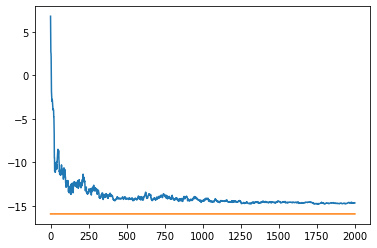

In [434]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)